# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd

import anndata
import scanpy as sc
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import scipy
from sklearn.preprocessing import minmax_scale
import seaborn as sn

In [3]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

re==2.2.1
joblib==1.2.0
numpy==1.23.4
numpy_groupies==0.9.20
pandas==1.5.1
anndata==0.8.0
scanpy==1.9.3
scipy==1.9.3
seaborn==0.12.1


In [3]:
np.set_printoptions(linewidth=150)

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

sc.settings.verbosity = 0
sk.set_figsize((4, 4))

In [4]:
from time import localtime, strftime


def timestamp(date_only=True):
    stamp_format = "%Y%m%d" if date_only else "%Y%m%d-%H%M"
    return strftime(stamp_format, localtime())

# Load data

In [5]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

## fetal skin

In [6]:
fetal_object = 'fetal_skin.norm.maternal_removed.20220202.h5ad'
fetal_path = root_path + fetal_object
fetal_ad0 = sc.read(fetal_path)

In [7]:
fetal_ad0.shape

(186533, 28885)

what metadata is available in fetal skin?

In [8]:
fetal_ad0.obs.columns

Index(['sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample',
       'chemistry_sorting', 'cell_caller', 'scrublet_score',
       'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts',
       'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb',
       'independent_annotation_refined', 'independent_annotation_broad1',
       'independent_annotation_broad2', 'independent_annotation_broad3',
       'independent_annotation_broad4', 'independent_annotation_broad5',
       'joint_annotation', 'is_maternal', 'fig1b_annotation',
       'independent_annotation_refined_20220201a',
       'independent_annotation_refined_20220201b',
       'independent_annotation_broad1_20220201',
       'independent_annotation_broad2_20220201',
       'independent_annotation_broad3_20220201', 'joint_annotation_20220201a',
       'joint_annotation_20220201b', 'fig1b_annotation_20220201',
       'fig1b_annotation_20220202', 'joint_annotation_20220202',
       'fig1b_annotatio

What's in "pcw"?

In [9]:
fetal_ad0.obs.pcw.value_counts(dropna=False).sort_index()

7     34565
8     13641
9     15310
10     5231
11    18465
12     7211
13    13434
14    25949
15    46656
16     6071
Name: pcw, dtype: int64

what's in "fig1b_annotation_v2"

In [10]:
fetal_ad0.obs.fig1b_annotation_v2.cat.categories

Index(['Neuronal cells', 'Schwann cell', 'Fibroblast', 'Skeletal muscle',
       'Mural cell', 'Vascular endothelium', 'Erythroid', 'Macrophage', 'ILC',
       'Keratinocyte', 'Melanocyte', 'Haem progenitor', 'Megakaryocyte',
       'Neutrophil', 'Mast cell', 'DC', 'Monocyte', 'Lymphatic endothelium',
       'T cell', 'B cell', 'Adipocyte'],
      dtype='object')

In [11]:
fetal_ad0.obs.fig1b_annotation_v2.cat.rename_categories(
    {"Neuronal cells": "Neuronal cell"}, inplace=True
)

what's in "joint_annotation"

In [12]:
fetal_ad0.obs.loc[
    fetal_ad0.obs.fig1b_annotation_v2 == "Keratinocyte", "joint_annotation_20220202"
].value_counts().where(lambda x: x > 0).dropna()

DPYSL2+ basal          815.0
Placode/matrix         254.0
Periderm               153.0
Immature basal          65.0
POSTN+ basal            46.0
Suprabasal IFE          30.0
Companion layer         27.0
Outer root sheath       25.0
Cuticle/cortex          21.0
Inner root sheath       18.0
Immature suprabasal     15.0
Name: joint_annotation_20220202, dtype: float64

what type of data is in "X"?

In [13]:
fetal_ad0.X.data

array([1.8038048, 1.4774609, 1.4774609, ..., 1.6299081, 2.2199435, 2.8572528], dtype=float32)

In [14]:
np.expm1(
    fetal_ad0.X[
        0:5,
    ]
).sum(axis=1)

matrix([[10005.071],
        [10006.827],
        [10006.456],
        [10006.766],
        [10001.346]], dtype=float32)

ok, seems it's log1p-transformed normalised values

## adult skin

In [15]:
adult_object = 'Healthy_all_data.h5ad'
adult_path = root_path + adult_object
adult_ad0 = sc.read(adult_path)

In [16]:
adult_ad0.shape

(217266, 33538)

In [17]:
adult_ad0

AnnData object with n_obs × n_vars = 217266 × 33538
    obs: 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage', 'anno_final', 'final'
    var: 'gene_ids', 'feature_types'

In [18]:
sk.calculate_qc(adult_ad0)

what metadata is available in adult skin?

In [19]:
adult_ad0.obs.columns

Index(['sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue',
       'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage',
       'anno_final', 'final', 'n_counts', 'log1p_n_counts', 'n_genes',
       'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo',
       'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50'],
      dtype='object')

what's in "Age"?

In [20]:
adult_ad0.obs.Age.value_counts(dropna=False)

NaN    217266
Name: Age, dtype: int64

ok, basically no age information, set them to pcw 999 (40 + 18 * 52 = 976)

In [21]:
adult_ad0.obs["pcw"] = 999

there were some nan in cell type annotation in adult skin?

In [22]:
adult_ad0.obs.anno_final.value_counts(dropna=False).index.sort_values()

CategoricalIndex(['C_Melanocyte', 'DC1', 'DC2', 'F1', 'F2', 'F3', 'ILC1',
                  'ILC1_NK', 'ILC2_3', 'Inf_mono', 'LC_1', 'LC_2', 'LC_3',
                  'LC_4', 'LE1', 'LE2', 'M_A_Mast_cell', 'Macro_1', 'Macro_2',
                  'MigDC', 'Mono', 'NK', 'Pericyte_1_non_inflamm',
                  'Pericyte_2_inflamm', 'Plasma',
                  'Schwaan_1_Stroma_Schwan_myelinating',
                  'Schwaan_2_non_myelinating', 'Tc', 'Th', 'Treg', 'VE1',
                  'VE2', 'VE3', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
                  'moDC_1', 'moDC_2', 'moDC_3', 'nan'],
                 categories=['C_Melanocyte', 'DC1', 'DC2', 'F1', ..., 'moDC_1', 'moDC_2', 'moDC_3', 'nan'], ordered=False, dtype='category')

there's indeed nan, let's remove them

In [23]:
adult_ad0 = adult_ad0[adult_ad0.obs.anno_final.astype(str) != "nan"].copy()

make some broad annotations similar to that of fig1b_annotation in fetal skin

In [ ]:
#'Neuronal cells', 'Schwann cell', 'Fibroblast', 'Skeletal muscle',
#       'Mural cell', 'Vascular endothelium', 'Erythroid', 'Macrophage', 'ILC',
#       'Keratinocyte', 'Melanocyte', 'Haem progenitor', 'Megakaryocyte',
#       'Neutrophil', 'Mast cell', 'DC', 'Monocyte', 'Lymphatic endothelium',
#       'T cell', 'B cell', 'Adipocyte'

In [24]:
adult_ad0.obs["anno_broad"] = sk.regroup(
    adult_ad0,
    groupby="anno_final",
    regroups={
        "ILC": ["ILC1", "ILC1_NK", "ILC2_3", "NK"],
        "T cell": ["Tc", "Th", "Treg"],
        "Plasma cell": ["Plasma"],
        "Monocyte": ["Inf_mono", "Mono"],
        "Macrophage": ["Macro_1", "Macro_2"],
        "DC": ["DC1", "DC2", "MigDC", "moDC_1", "moDC_2", "moDC_3", "LC_1", "LC_2", "LC_3", "LC_4"],
        #"Langerhans cell": ["LC_1", "LC_2", "LC_3", "LC_4"],
        "Mast cell": ["M_A_Mast_cell"],
        "Fibroblast": ["F1", "F2", "F3"],
        "Mural cell": ["Pericyte_1_non_inflamm", "Pericyte_2_inflamm"],
        "Keratinocyte": ["c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"],
        "Melanocyte": ["C_Melanocyte"],
        "Lymphatic endothelium": ["LE1", "LE2"],
        "Vascular endothelium": ["VE1", "VE2", "VE3"],
        "Schwann cell": ["Schwaan_1_Stroma_Schwan_myelinating", "Schwaan_2_non_myelinating"],
    },
)

In [25]:
adult_ad0.obs.anno_broad.value_counts(dropna=False).index

CategoricalIndex(['Keratinocyte', 'T cell', 'DC', 'Vascular endothelium',
                  'Fibroblast', 'Macrophage', 'ILC', 'Monocyte', 'Mural cell',
                  'Lymphatic endothelium', 'Melanocyte', 'Mast cell',
                  'Schwann cell', 'Plasma cell'],
                 categories=['ILC', 'T cell', 'Plasma cell', 'Monocyte', ..., 'Melanocyte', 'Lymphatic endothelium', 'Vascular endothelium', 'Schwann cell'], ordered=False, dtype='category')

what type of data is in "X"?

In [26]:
adult_ad0.X.data

array([6., 2., 3., ..., 1., 2., 1.], dtype=float32)

ok, seems it's raw counts

## skin organoid

In [27]:
organoid_object = 'organoid_day13_29_48_85_133.cellxgene.h5ad'
organoid_path = root_path + organoid_object
organoid_ad0 = sc.read(organoid_path)

In [28]:
organoid_ad0.shape

(123835, 38072)

what metadata is available in organoid data?

In [29]:
organoid_ad0.obs.columns

Index(['day', 'sample_id', 'strain', 'version', 'week', 'nh3_annot1',
       'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes',
       'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo',
       'percent_hb', 'n_counts_hb', 'percent_top50', 'pass_auto_filter',
       'scrublet_score', 'scrublet_score_z', 'cluster_scrublet_score',
       'bh_pval', 'scrublet_done', 'doublet', 'seurat_clusters',
       'fsk_annot1_min30', 'fsk_annot1_min30_prob', 'fsk_annot2_min30',
       'fsk_annot2_min30_prob', 'day8to13', 'org_annot0_prob', 'org_annot30',
       'org_annot30_prob', 'fsk_annot0', 'fsk_annot0_prob', 'fsk_annot30',
       'fsk_annot30_prob', 'org_annot0'],
      dtype='object')

what's in "day"?

In [30]:
organoid_ad0.obs.day.value_counts(dropna=False).sort_index()

day-13      9557
day-29     16176
day-48     18898
day-85     15948
day-133    63256
Name: day, dtype: int64

what's in "week"?

In [31]:
organoid_ad0.obs.week.value_counts(dropna=False).sort_index()

4-7_fetal_wks      16176
7-10_fetal_wks     18898
14-16_fetal_wks    15948
17-20_fetal_wks    63256
nan                 9557
Name: week, dtype: int64

Set "pcw" from "day"

In [32]:
organoid_ad0.obs["pcw"] = (
    (organoid_ad0.obs.day.str.replace("day-", "").astype(int) / 7).round().astype(int)
)

what's in "strain"?

In [33]:
organoid_ad0.obs.strain.value_counts(dropna=False).sort_index()

DSP     65903
WA25    57932
Name: strain, dtype: int64

what's in "org_annot0"?

In [34]:
organoid_ad0.obs.org_annot0.value_counts(dropna=False).sort_index().index

CategoricalIndex(['organoid_Adipocytes', 'organoid_Basal',
                  'organoid_Basal POSTN+', 'organoid_Placode/matrix',
                  'organoid_Companion layer', 'organoid_Cuticle/cortex',
                  'organoid_Dermal condensate', 'organoid_Dermal papilla',
                  'organoid_Early fibroblasts FRZB+',
                  'organoid_Early fibroblasts HOXC5+',
                  'organoid_Early myocytes', 'organoid_Fibroblasts POSTN+',
                  'organoid_Immature basal', 'organoid_Immature suprabasal',
                  'organoid_Inner root sheath', 'organoid_Melanoblasts',
                  'organoid_Melanocytes', 'organoid_Merkel cells',
                  'organoid_Myelinating Schwann cells', 'organoid_Myoblasts',
                  'organoid_Myocytes', 'organoid_Neuroepithelial cells',
                  'organoid_Neuron progenitors',
                  'organoid_Neuron progenitors SPP1+',
                  'organoid_Outer root sheath', 'organoid_Periderm

make some broad annotations similar to that of fig1b_annotation in fetal skin

In [35]:
organoid_ad0.obs["org_annot0_broad"] = sk.regroup(
    organoid_ad0,
    groupby="org_annot0",
    regroups={
        "Adipocyte": ["organoid_Adipocytes"],
        #"Dermal papillia": ["organoid_Dermal papillia"],
        "Fibroblast": [
            "organoid_Dermal condensate",
            "organoid_Early fibroblasts FRZB+",
            "organoid_Early fibroblasts HOXC5+",
            "organoid_Fibroblasts POSTN+",
            "organoid_Pre-dermal condensate",
            "organoid_Dermal papilla"
        ],
        "Keratinocyte": [
            "organoid_Basal",
            "organoid_Basal POSTN+",
            "organoid_Placode/matrix",
            "organoid_Companion layer",
            "organoid_Cuticle/cortex",
            "organoid_Immature basal",
            "organoid_Immature suprabasal",
            "organoid_Inner root sheath",
            "organoid_Outer root sheath",
            "organoid_Periderm",
            "organoid_Suprabasal IFE",
        ],
        "Melanocyte": [
            "organoid_Melanoblasts",
            "organoid_Proliferating melanoblasts",
            "organoid_Melanocytes",
        ],
        "Skeletal muscle": [
            "organoid_Early myocytes",
            "organoid_Myoblasts",
            "organoid_Myocytes",
        ],
        "Mural cell": ["organoid_Smooth muscle/Pericytes"],
        "Neuronal cell": [
            "organoid_Neuroepithelial cells",
            "organoid_Neuron progenitors",
            "organoid_Neuron progenitors SPP1+",
            "organoid_Secreting neuron",
            "organoid_Merkel cells",
        ],
        "Schwann cell": [
            "organoid_Myelinating Schwann cells",
            "organoid_Schwann cells/Schwann precursors",
        ],
        "Vascular endothelium": ["organoid_Capillary arterioles"],
    },
)
organoid_ad0.obs["org_annot0_broad"] = organoid_ad0.obs["org_annot0_broad"].astype("category")

In [36]:
np.expm1(
    organoid_ad0.X[
        0:5,
    ]
).sum(axis=1)

matrix([[ 9999.999],
        [10000.   ],
        [ 9999.999],
        [10000.   ],
        [ 9999.998]], dtype=float32)

ok, seems it's log1p-transformed normalised values

# Down-sample and pool

In [37]:
fetal_adS = sk.subsample(fetal_ad0, 1, groupby="fig1b_annotation_v2", min_n=500, max_n=500)

In [38]:
organoid_adS = sk.subsample(organoid_ad0, 1, groupby="org_annot0_broad", min_n=500, max_n=500)

In [39]:
adult_adS = sk.subsample(adult_ad0, 1, groupby="anno_broad", min_n=500, max_n=500)

In [40]:
pooled_adS = sk.integrate(
    [fetal_adS, organoid_adS, adult_adS],
    ad_prefices=["fetal", "organoid", "adult"],
    ad_types=["norm", "norm", "counts"],
    annotations=["fig1b_annotation_v2", "org_annot0_broad", "anno_broad"],
    batches=["donor", "strain", "donor_id"],
    pool_only=True,
    join="outer",
)

In [41]:
pooled_adS

AnnData object with n_obs × n_vars = 20406 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_i

In [42]:
pooled_adS.var["n_counts"] = (
    pooled_adS.var["n_counts-adult"].fillna(0)
    + pooled_adS.var["n_counts-fetal"].fillna(0)
    + pooled_adS.var["n_counts-organoid"].fillna(0)
)

pooled_adS.var["n_cells"] = (
    pooled_adS.var["n_cells-adult"].fillna(0)
    + pooled_adS.var["n_cells-fetal"].fillna(0)
    + pooled_adS.var["n_cells-organoid"].fillna(0)
)

In [43]:
sk.calculate_qc(pooled_adS, flag_only=True)

In [44]:
pooled_adS.var = pooled_adS.var[["mito", "ribo", "hb", "n_counts", "n_cells"]].copy()

In [45]:
pooled_adS

AnnData object with n_obs × n_vars = 20406 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_i

In [46]:
pooled_adS.obs.pcw.value_counts(dropna=False).sort_index()

2       556
4       387
7      2198
8       271
9       553
10       83
11      933
12     1021
13      931
14     1717
15     3210
16      482
19     1724
999    6340
Name: pcw, dtype: int64

In [47]:
pooled_adS.obs.log2pcw = np.log2(pooled_adS.obs.pcw)

In [48]:
pooled_adS.obs.batch.value_counts(dropna=False).sort_index()

DSP     2323
F16       59
F17       37
F19       83
F32      219
F33      516
F34      212
F35      247
F38      931
F41      482
F45      421
F50     1524
F51     1686
F61      868
F69      933
F71     1717
S1      1529
S2       855
S3       535
S4      1559
S5      1862
WA25    1808
Name: batch, dtype: int64

In [49]:
pooled_adS.obs.dataset.value_counts(dropna=False).sort_index()

fetal       9935
organoid    4131
adult       6340
Name: dataset, dtype: int64

In [50]:
pooled_adS.obs.annot.value_counts(dropna=False).sort_index()

adult_DC                         500
adult_Fibroblast                 500
adult_ILC                        500
adult_Keratinocyte               500
adult_Lymphatic endothelium      500
adult_Macrophage                 500
adult_Mast cell                  500
adult_Melanocyte                 500
adult_Monocyte                   500
adult_Mural cell                 500
adult_Plasma cell                 71
adult_Schwann cell               269
adult_T cell                     500
adult_Vascular endothelium       500
fetal_Adipocyte                  500
fetal_B cell                     500
fetal_DC                         500
fetal_Erythroid                  500
fetal_Fibroblast                 500
fetal_Haem progenitor            500
fetal_ILC                        500
fetal_Keratinocyte               500
fetal_Lymphatic endothelium      500
fetal_Macrophage                 500
fetal_Mast cell                  500
fetal_Megakaryocyte              173
fetal_Melanocyte                 500
f

In [51]:
pooled_adS1 = sk.simple_default_pipeline(
    pooled_adS.copy(),
    post_norm_only=True,
    batch_method="harmony",
    batch=["dataset", "batch"],
    do_clustering=False,
    hvg_kw={"by_batch": ("dataset", 1), "n_hvg": 2000, "subset": True},
    pca_kw={"remove_genes": ["ribo", "mito"]},
)

2023-06-30 10:59:06,282 - harmonypy - INFO - Iteration 1 of 20
2023-06-30 10:59:55,362 - harmonypy - INFO - Iteration 2 of 20
2023-06-30 11:00:44,062 - harmonypy - INFO - Iteration 3 of 20
2023-06-30 11:01:34,562 - harmonypy - INFO - Iteration 4 of 20
2023-06-30 11:02:22,463 - harmonypy - INFO - Iteration 5 of 20
2023-06-30 11:03:08,660 - harmonypy - INFO - Iteration 6 of 20
2023-06-30 11:03:58,257 - harmonypy - INFO - Iteration 7 of 20
2023-06-30 11:04:47,965 - harmonypy - INFO - Iteration 8 of 20
2023-06-30 11:05:26,156 - harmonypy - INFO - Iteration 9 of 20
2023-06-30 11:06:15,464 - harmonypy - INFO - Converged after 9 iterations


In [52]:
pooled_adS1.obs["log2pcw"] = np.log2(pooled_adS1.obs.pcw)
pooled_adS1.obs["log2pcw"] = pooled_adS1.obs["log2pcw"].astype("category")

In [53]:
pooled_adS1

AnnData object with n_obs × n_vars = 20406 × 29447
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_i

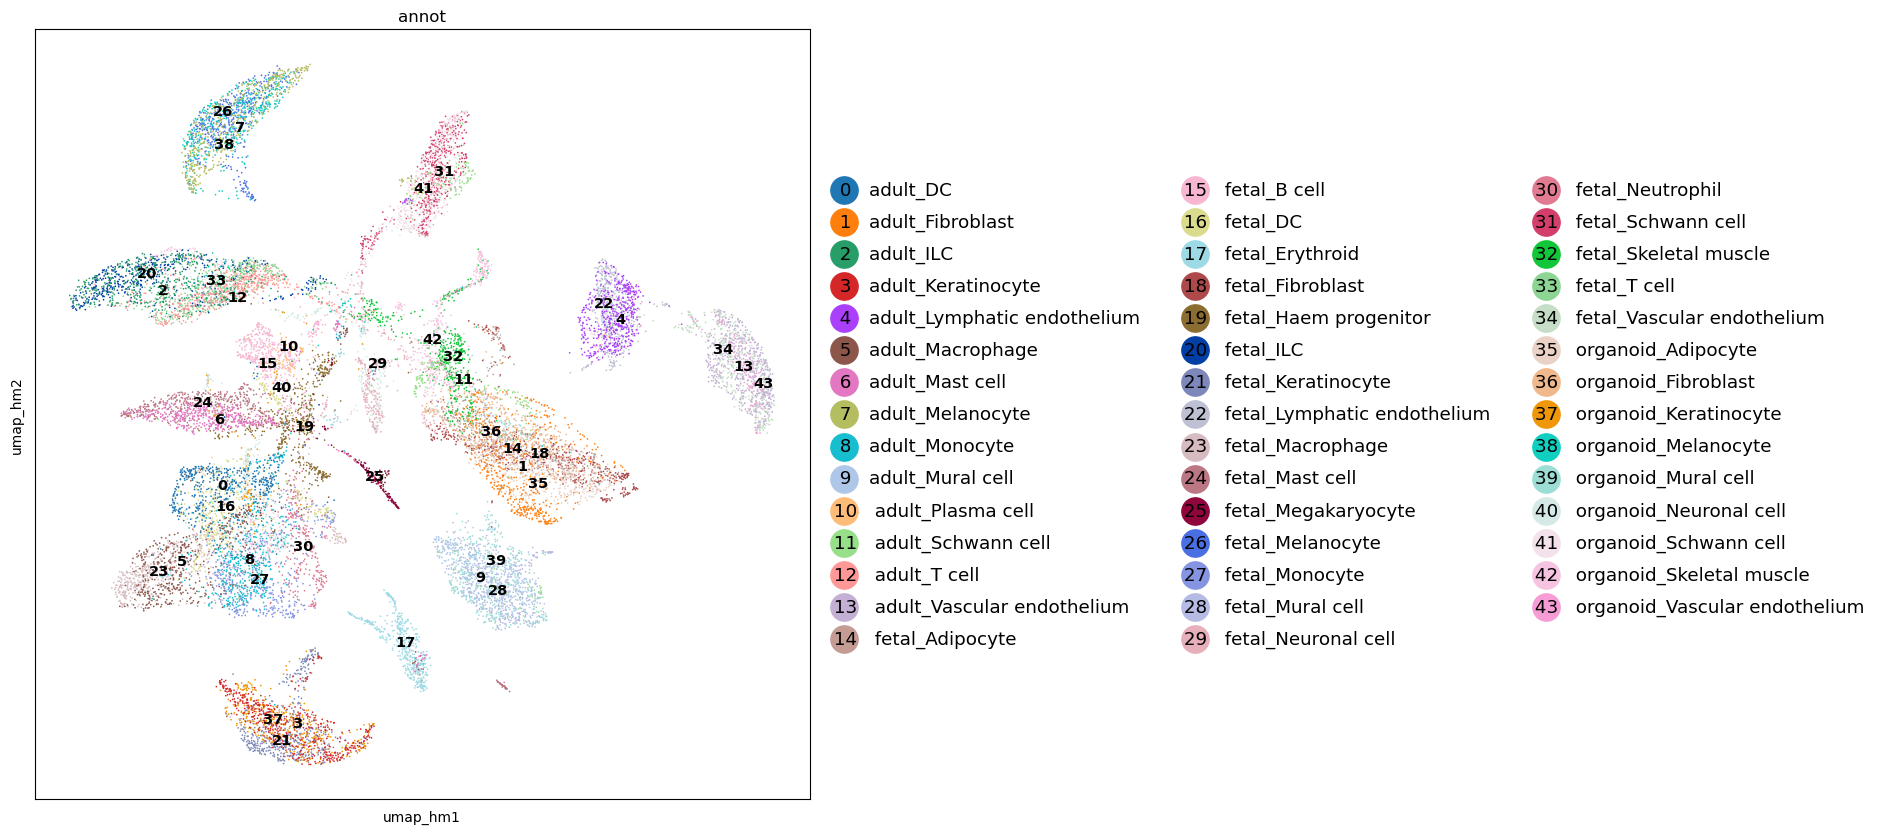

In [54]:
sk.plot_embedding(
    pooled_adS1, basis="umap_hm", groupby="annot", figsize=(10, 10), legend_fontsize=12
);

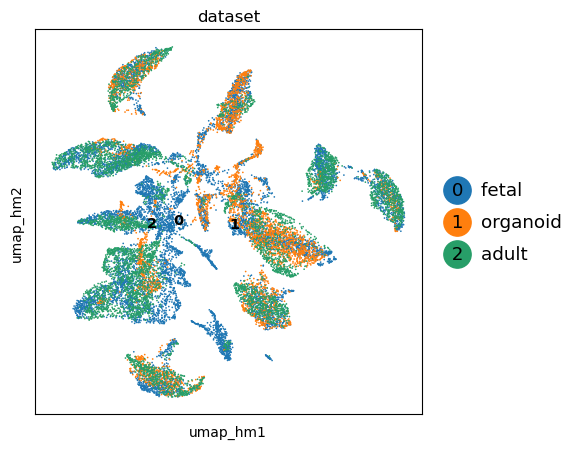

In [55]:
sk.plot_embedding(
    pooled_adS1, basis="umap_hm", groupby="dataset", figsize=(5, 5), legend_fontsize=12
);

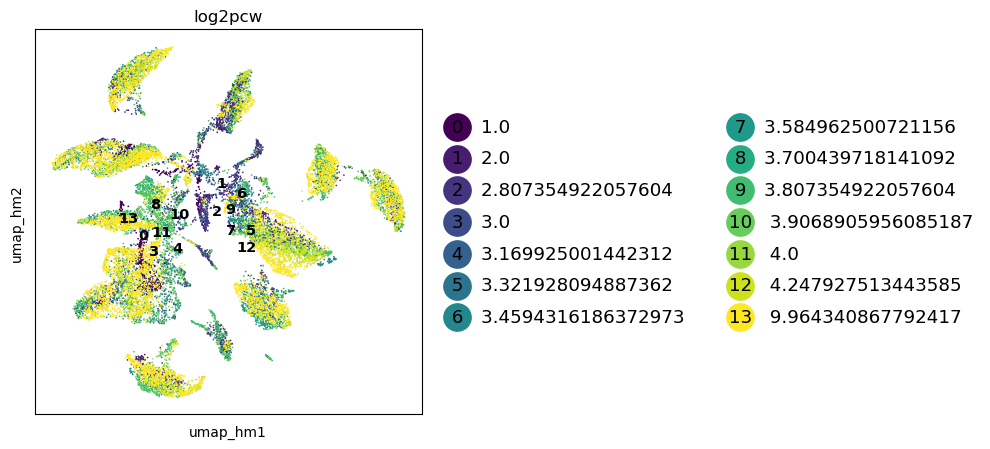

In [56]:
sk.plot_embedding(
    pooled_adS1,
    basis="umap_hm",
    groupby="log2pcw",
    figsize=(5, 5),
    palette="viridis",
    legend_fontsize=12,
);

In [59]:
#pooled_adS1.write(
#    "pooled_fetal_organoid_adult.downsampled.harmony_integrated.norm.h5ad", compression="lzf"
#)

In [4]:
#pooled_adS1 = sc.read("pooled_fetal_organoid_adult.downsampled.harmony_integrated.norm.h5ad")

# Pool

pool fetal and adult with the union of genes

In [57]:
pooled_ad0 = sk.integrate(
    [fetal_ad0, organoid_ad0, adult_ad0],
    ad_prefices=["fetal", "organoid", "adult"],
    ad_types=["norm", "norm", "counts"],
    annotations=["fig1b_annotation_v2", "org_annot0_broad", "anno_broad"],
    batches=["donor", "strain", "donor_id"],
    pool_only=True,
    join="outer",
)

In [58]:
pooled_ad0.var["n_counts"] = (
    pooled_ad0.var["n_counts-adult"].fillna(0)
    + pooled_ad0.var["n_counts-fetal"].fillna(0)
    + pooled_ad0.var["n_counts-organoid"].fillna(0)
)

In [59]:
pooled_ad0.var["n_cells"] = (
    pooled_ad0.var["n_cells-adult"].fillna(0)
    + pooled_ad0.var["n_cells-fetal"].fillna(0)
    + pooled_ad0.var["n_cells-organoid"].fillna(0)
)

In [60]:
sk.calculate_qc(pooled_ad0, flag_only=True)

In [61]:
pooled_ad0.var = pooled_ad0.var[["mito", "ribo", "hb", "n_counts", "n_cells"]].copy()

In [65]:
#pooled_ad0.write("pooled_fetal_organoid_adult.norm.h5ad", compression="lzf")

... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'fig1b_annotation' as categorical
... storing 'independent_annotation_refined_20220201a' as categorical
... storing 'independent_annotation_refined_20220201b' as categorical
... storing 'independent_annotation_broad1_20220201' as catego

# Integrate

In [62]:
#pooled_ad0 = sc.read("h5ad/pooled_fetal_organoid_adult.norm.h5ad")

In [63]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_

In [64]:
pooled_adS1

AnnData object with n_obs × n_vars = 20406 × 29447
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_i

In [65]:
pooled_adS2 = pooled_adS1[:, pooled_adS1.var.highly_variable].copy()

In [66]:
proj_results = sk._utils.project_into_PC(
    pooled_ad0, pooled_adS2, target_pca="X_pca_hm", key_added="project"
)

In [67]:
sk.neighbors(pooled_ad0, use_rep="X_pca_project", key_added="project")
sk.umap(pooled_ad0, use_graph="neighbors_project")

In [68]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_

In [69]:
pooled_ad0.obs["log2pcw"] = np.log2(pooled_ad0.obs.pcw)

figS1E

In [3]:
#pooled_ad0 = sc.read("pooled_fetal_organoid_adult.processed.h5ad", backed="r")

<AxesSubplot: title={'center': 'annot'}, xlabel='UMAP1', ylabel='UMAP2'>

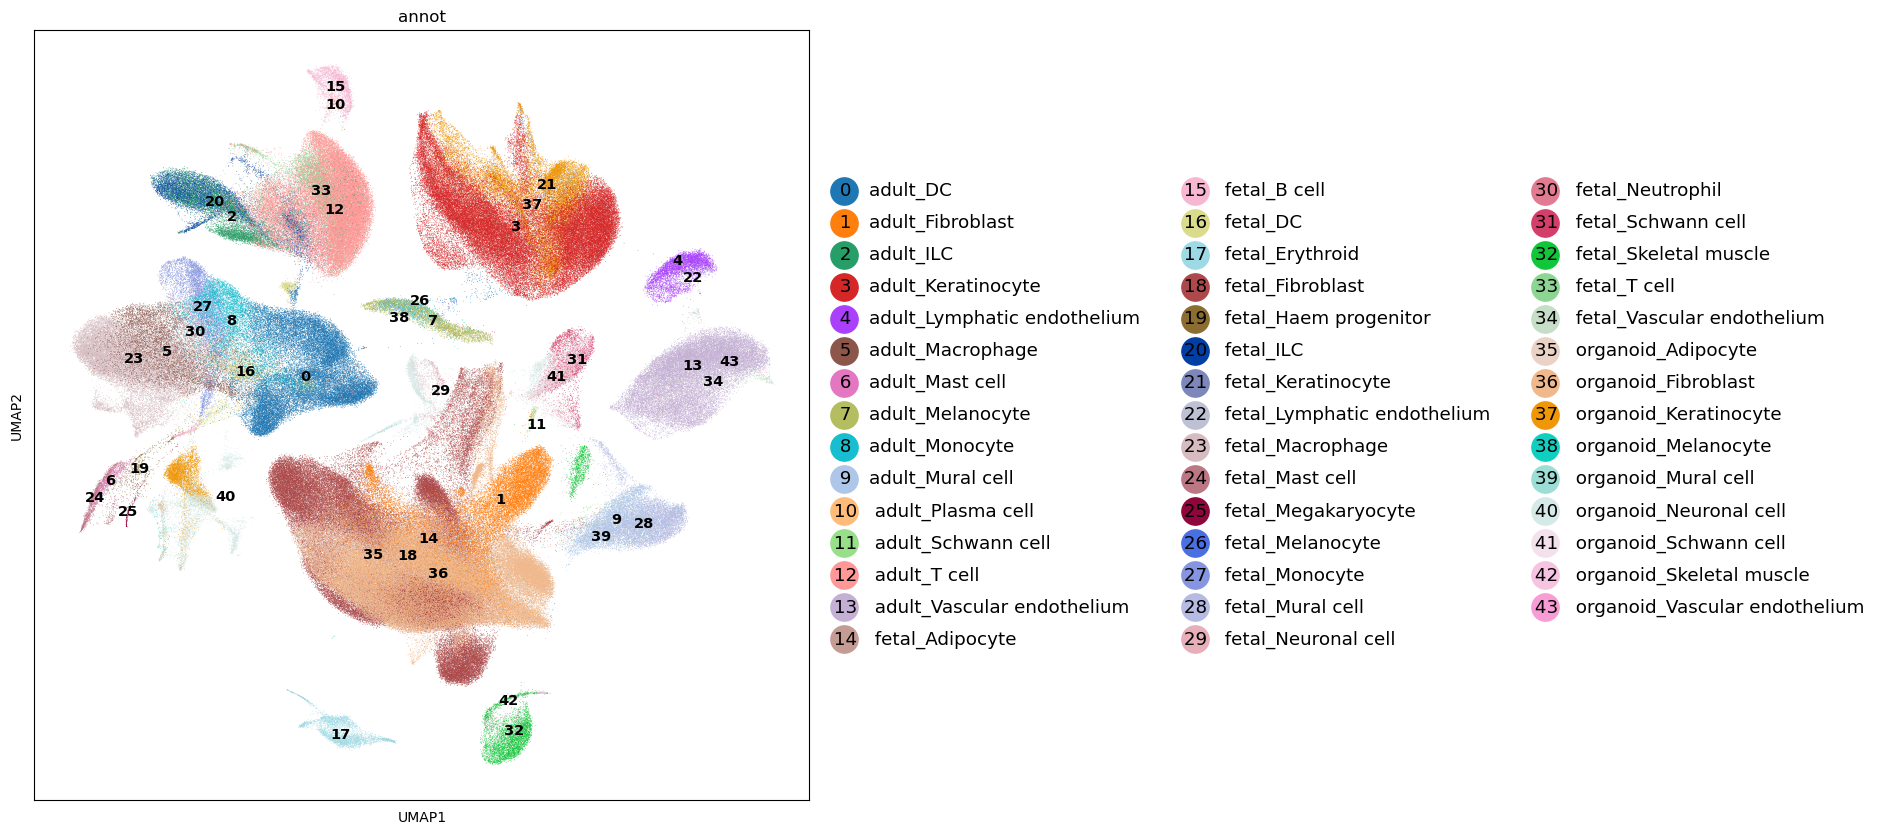

In [70]:
sk.plot_embedding(
    pooled_ad0,
    basis="umap",
    groupby="annot",
    figsize=(10, 10),
    legend_fontsize=12,
    size=1,
)

In [71]:
os.getcwd()

'/home/jovyan/projects/skin/fetal_skin/notebooks_upload/Sorted/Updated'

In [70]:
%%capture

with PdfPages("figures/figS1E.pdf") as pdf:
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(15, 15),
        legend_fontsize=12,
        size=2,
    )
    pdf.savefig(bbox_inches="tight")
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(15, 15),
        legend_fontsize=12,
        size=2,
        annot="none",
        frameon=False,
    )
    pdf.savefig(bbox_inches="tight")

In [155]:
#!rclone copy --drive-shared-with-me figures/figS1E.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [71]:
%%capture

sc.settings.set_figure_params(dpi_save=80)
with PdfPages("figures/figS1E_smaller.pdf") as pdf:
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(10, 10),
        legend_fontsize=12,
        size=0.75,
    )
    pdf.savefig(bbox_inches="tight")
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(10, 10),
        legend_fontsize=12,
        size=0.75,
        annot="none",
        frameon=False,
    )
    pdf.savefig(bbox_inches="tight", dpi=80)

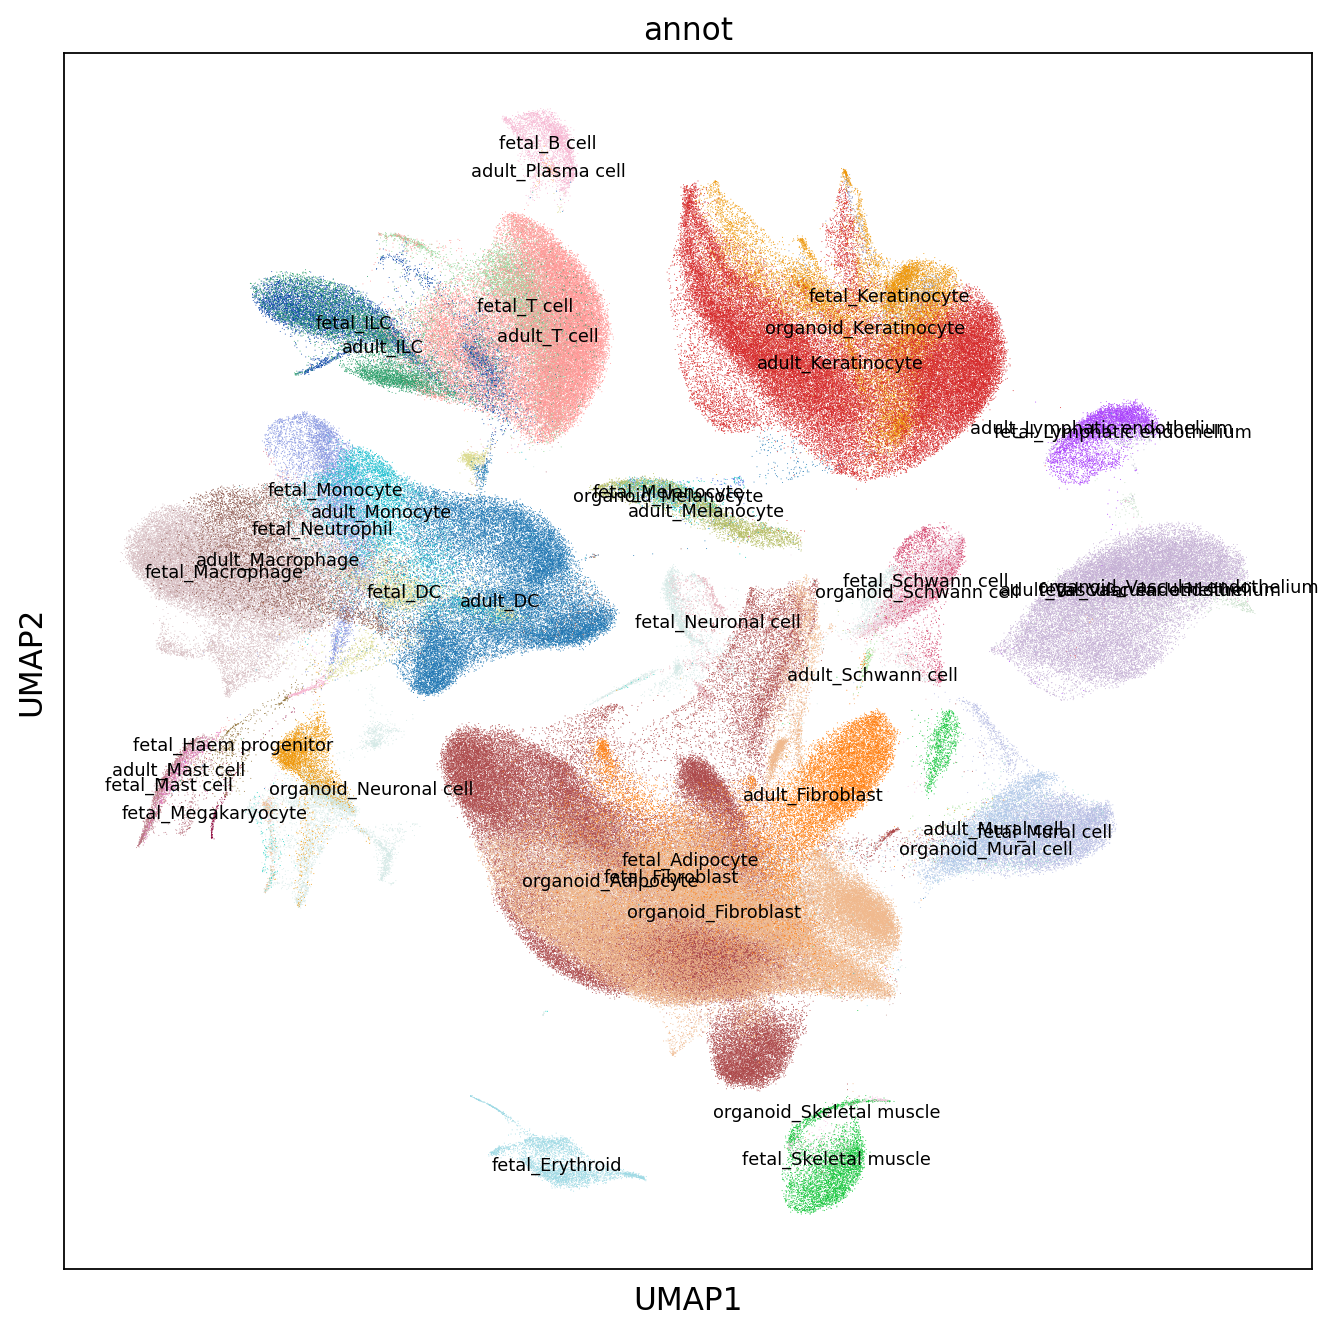

In [80]:
sc.pl.embedding(pooled_ad0, basis="umap", color="annot", legend_fontsize=8, legend_loc='on data', legend_fontweight='light',
                size=0.75, return_fig=True).savefig('/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/notebooks_lustre/figures/combined_umap2.pdf')

In [5]:
#!rclone copy --drive-shared-with-me figures/figS1E_smaller.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

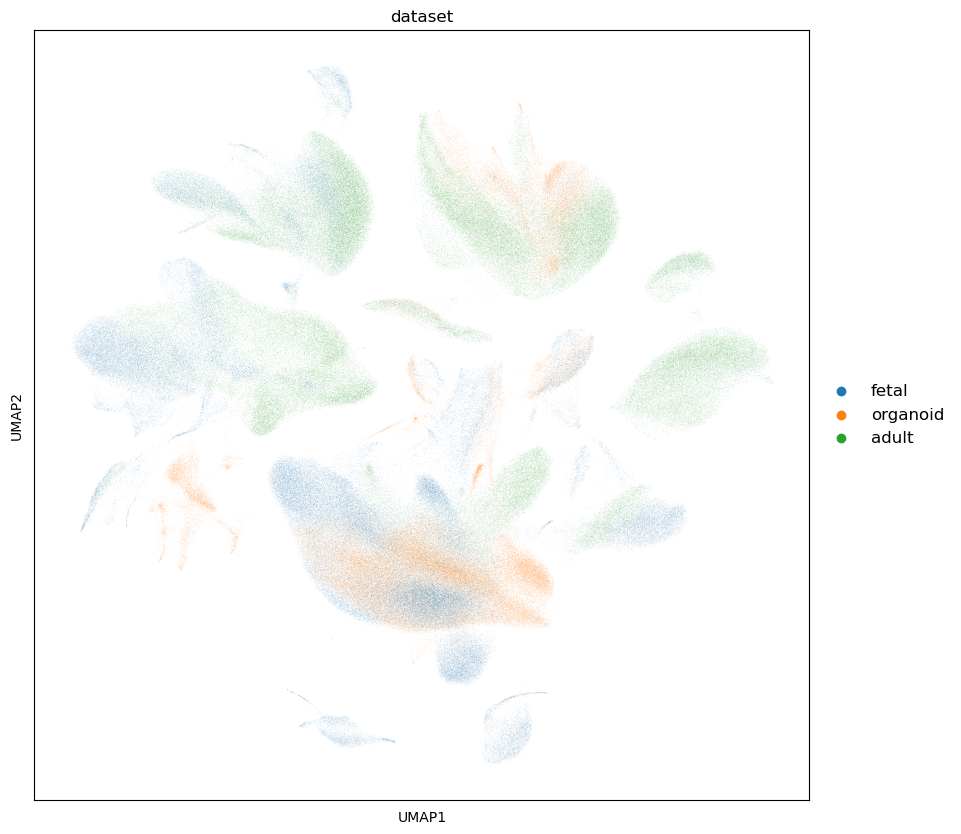

In [72]:
sc.pl.embedding(pooled_ad0, basis="umap", color="dataset", legend_fontsize=12, size=0.1);

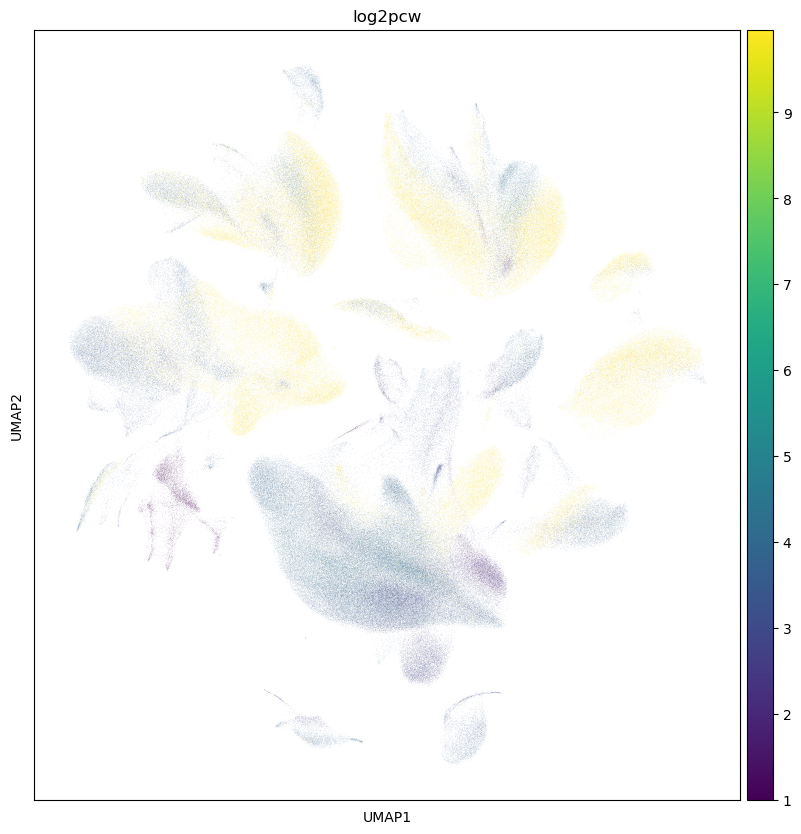

In [73]:
sc.pl.embedding(pooled_ad0, basis="umap", color="log2pcw", legend_fontsize=12, size=0.1);

In [74]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_

In [75]:
pooled_ad0.obs['is_maternal'].value_counts(dropna=False)

NaN      319574
False    186533
Name: is_maternal, dtype: int64

In [76]:
pooled_ad0.obs['pass_auto_filter'].value_counts(dropna=False)

NaN     382272
True    123835
Name: pass_auto_filter, dtype: int64

In [77]:
pooled_ad0.obs['doublet'].value_counts(dropna=False)

NaN      382272
False    123835
Name: doublet, dtype: int64

In [78]:
pooled_ad0.obs['mad_prd'].value_counts(dropna=False)

NaN      310368
False    195739
Name: mad_prd, dtype: int64

In [79]:
pooled_ad0.obs['is_maternal'] = pooled_ad0.obs['is_maternal'].astype('category')
pooled_ad0.obs['pass_auto_filter'] = pooled_ad0.obs['pass_auto_filter'].astype('category')
pooled_ad0.obs['doublet'] = pooled_ad0.obs['doublet'].astype('category')
pooled_ad0.obs['mad_prd'] = pooled_ad0.obs['mad_prd'].astype('category')

In [80]:
#pooled_ad0.write("/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/pooled_fetal_organoid_adult.processed.h5ad")

# plot umap pooled prenatal skin, adult skin and skin organoid

In [81]:
#"/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/pooled_fetal_organoid_adult.processed.h5ad"
#pooled_ad = pooled_ad0

pooled_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/pooled_fetal_organoid_adult.processed.h5ad'
pooled_ad = sc.read(pooled_path)

In [82]:
pooled_ad

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_

In [83]:
pooled_ad.obs.dataset.unique()

['fetal', 'organoid', 'adult']
Categories (3, object): ['fetal', 'organoid', 'adult']

<AxesSubplot: title={'center': 'annot'}, xlabel='UMAP1', ylabel='UMAP2'>

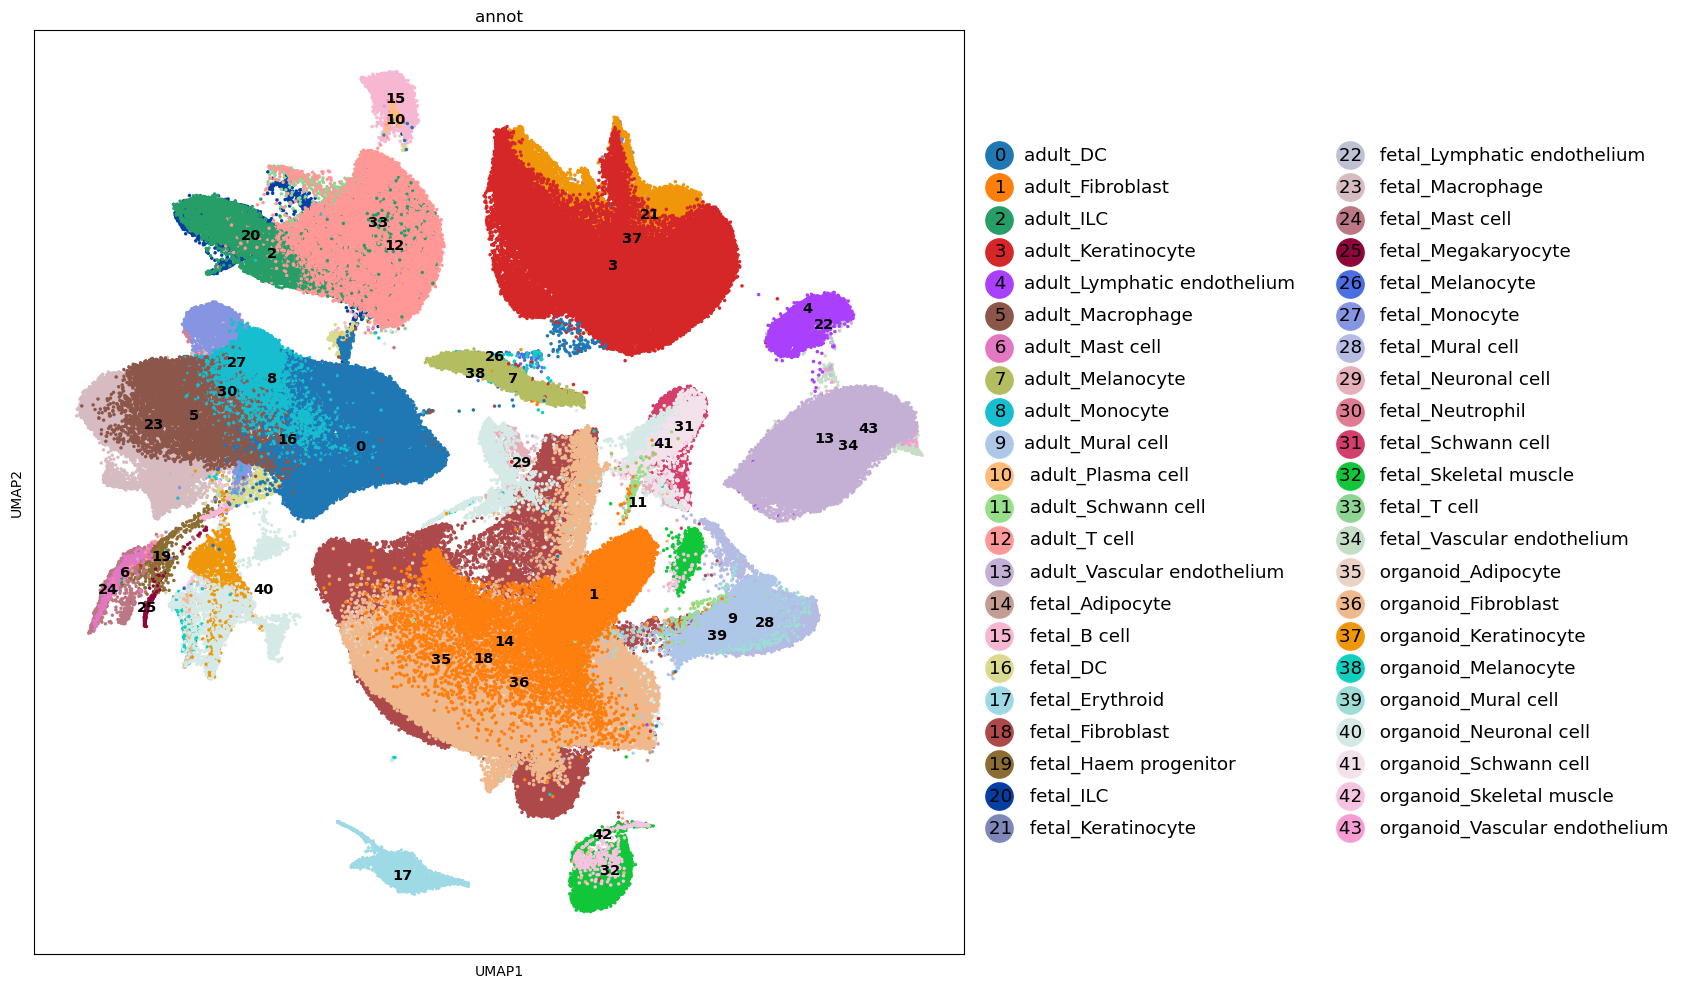

In [84]:
sk.plot_embedding(pooled_ad,
    basis="umap",
    groupby="annot",
    size=25,
    legend_fontsize=12,
    figsize=(12, 12))

<AxesSubplot: title={'center': 'dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

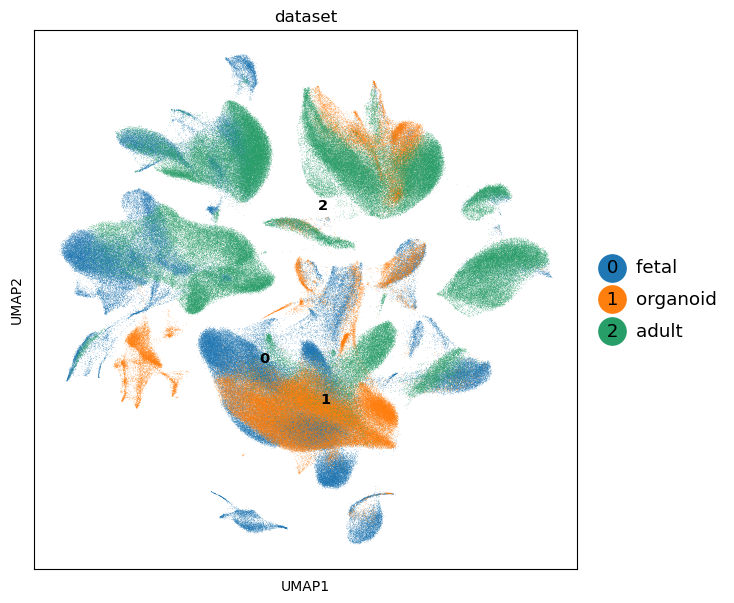

In [85]:
#colour by dataset
sk.plot_embedding(pooled_ad,
    basis="umap",
    groupby="dataset",
    size=0.5,
    legend_fontsize=12,
    figsize=(7, 7))

In [86]:
#sk.set_figsize((7,7))
#sc.pl.embedding(pooled_ad, basis='X_umap', color=['dataset'], s=0.5,
#                      palette={'fetal': 'tab:green',
#                                'organoid': 'tab:purple', 
#                                'adult': 'tab:orange'},
#                save= 'Fig5_combined_umap.pdf')

In [87]:
print(list(pooled_ad.obs['annot'].unique()))

['fetal_Macrophage', 'fetal_Monocyte', 'fetal_Haem progenitor', 'fetal_DC', 'fetal_Fibroblast', 'fetal_ILC', 'fetal_B cell', 'fetal_T cell', 'fetal_Lymphatic endothelium', 'fetal_Skeletal muscle', 'fetal_Mast cell', 'fetal_Vascular endothelium', 'fetal_Neutrophil', 'fetal_Megakaryocyte', 'fetal_Erythroid', 'fetal_Mural cell', 'fetal_Neuronal cell', 'fetal_Schwann cell', 'fetal_Adipocyte', 'fetal_Keratinocyte', 'fetal_Melanocyte', 'organoid_Fibroblast', 'organoid_Keratinocyte', 'organoid_Adipocyte', 'organoid_Mural cell', 'organoid_Melanocyte', 'organoid_Neuronal cell', 'organoid_Schwann cell', 'organoid_Skeletal muscle', 'organoid_Vascular endothelium', 'adult_Keratinocyte', 'adult_Melanocyte', 'adult_Lymphatic endothelium', 'adult_Fibroblast', 'adult_DC', 'adult_T cell', 'adult_Vascular endothelium', 'adult_ILC', 'adult_Macrophage', 'adult_Plasma cell', 'adult_Monocyte', 'adult_Mural cell', 'adult_Schwann cell', 'adult_Mast cell']


In [88]:
pooled_ad.obs['broad_integrated'] = pooled_ad.obs['annot']

In [89]:
pooled_ad.obs.broad_integrated.replace({
'fetal_Macrophage': 'immune',
'fetal_Monocyte': 'immune', 
'fetal_Haem progenitor': 'immune',
'fetal_DC': 'immune',
'fetal_Fibroblast': 'dermal stroma',
'fetal_ILC': 'immune',
'fetal_B cell': 'immune',
'fetal_T cell': 'immune',
'fetal_Lymphatic endothelium': 'endothelium',
'fetal_Skeletal muscle': 'dermal stroma',
'fetal_Mast cell': 'immune',
'fetal_Vascular endothelium': 'endothelium',
'fetal_Neutrophil': 'immune',
'fetal_Langerhans cell': 'immune',
'fetal_Megakaryocyte': 'immune',
'fetal_Erythroid': 'erythroid',  
'fetal_Mural cell': 'dermal stroma', 
'fetal_Neuronal cell': 'neuronal', 
'fetal_Schwann cell': 'neuronal', 
'fetal_Adipocyte': 'dermal stroma', 
'fetal_Keratinocyte': 'epidermis', 
'fetal_Melanocyte': 'melanocyte', 
'organoid_Fibroblast': 'dermal stroma', 
'organoid_Keratinocyte': 'epidermis', 
'organoid_Adipocyte': 'dermal stroma', 
#'organoid_Dermal papillia': 'dermal stroma', 
'organoid_Mural cell': 'dermal stroma', 
'organoid_Melanocyte': 'melanocyte', 
'organoid_Neuronal cell': 'neuronal', 
'organoid_Schwann cell': 'neuronal', 
'organoid_Skeletal muscle': 'dermal stroma', 
'organoid_Vascular endothelium': 'endothelium',
'adult_Keratinocyte': 'epidermis', 
'adult_Melanocyte': 'melanocyte', 
'adult_Lymphatic endothelium': 'endothelium',
'adult_Fibroblast': 'dermal stroma',
'adult_DC': 'immune',
'adult_T cell': 'immune',
'adult_Vascular endothelium': 'endothelium',
'adult_ILC': 'immune',
'adult_Macrophage': 'immune',
'adult_Plasma cell': 'immune',
'adult_Monocyte': 'immune',
'adult_Mural cell': 'dermal stroma', 
'adult_Schwann cell': 'neuronal',
'adult_Mast cell': 'immune'
}, inplace=True)

In [90]:
pooled_ad_fs = pooled_ad[pooled_ad.obs['dataset'] == "fetal"]
pooled_ad_or = pooled_ad[pooled_ad.obs['dataset'] == "organoid"]
pooled_ad_at = pooled_ad[pooled_ad.obs['dataset'] == "adult"]

(-9.467181587219239, 27.06060733795166)

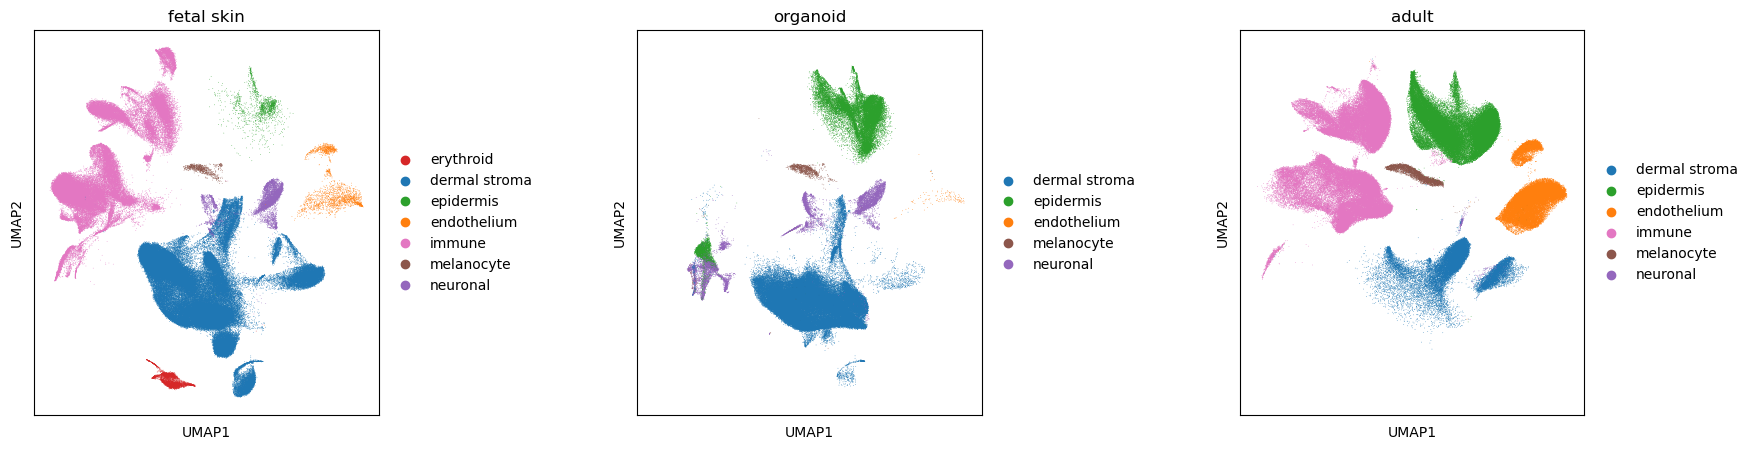

In [91]:
sk.set_figsize((20, 5))
fig = plt.figure()
spec = fig.add_gridspec(ncols=3, nrows=1)
spec.update(wspace=0.75, hspace=0.1) # set the spacing between axes.

f1 = fig.add_subplot(spec[0,0])
f2 = fig.add_subplot(spec[0,1])
f3 = fig.add_subplot(spec[0,2])

fig1 = sc.pl.embedding(pooled_ad_fs, basis='X_umap', color=['broad_integrated'], s=1, show=False, ax=f1, title='fetal skin',
                      palette={'erythroid': 'tab:red',
                                'dermal stroma': 'tab:blue', 
                                'epidermis': 'tab:green',
                                'endothelium': 'tab:orange',
                                'immune': 'tab:pink' ,
                                'melanocyte': 'tab:brown' ,
                                'neuronal': 'tab:purple'})
f1.set(xlabel="UMAP1", ylabel="UMAP2")

fig2 = sc.pl.embedding(pooled_ad_or, basis='X_umap', color=['broad_integrated'], s=1, show=False, ax=f2, title='organoid',
                      palette={'erythroid': 'tab:red',
                                'dermal stroma': 'tab:blue', 
                                'epidermis': 'tab:green',
                                'endothelium': 'tab:orange',
                                'immune': 'tab:pink' ,
                                'melanocyte': 'tab:brown' ,
                                'neuronal': 'tab:purple'})
f2.set(xlabel="UMAP1", ylabel="UMAP2")

fig3 = sc.pl.embedding(pooled_ad_at, basis='X_umap', color=['broad_integrated'], s=1, show=False, ax=f3, title='adult',
                        palette={'erythroid': 'tab:red',
                                'dermal stroma': 'tab:blue', 
                                'epidermis': 'tab:green',
                                'endothelium': 'tab:orange',
                                'immune': 'tab:pink' ,
                                'melanocyte': 'tab:brown' ,
                                'neuronal': 'tab:purple'})
f3.set(xlabel="UMAP1", ylabel="UMAP2")

f2.set_xlim((f1.get_xlim()))
f2.set_ylim((f1.get_ylim()))
f3.set_xlim((f1.get_xlim()))
f3.set_ylim((f1.get_ylim()))

#fig.savefig("/home/jovyan/projects/skin/fetal_skin/figures/other plots/Fig1_split_umaps2.pdf", bbox_inches="tight")

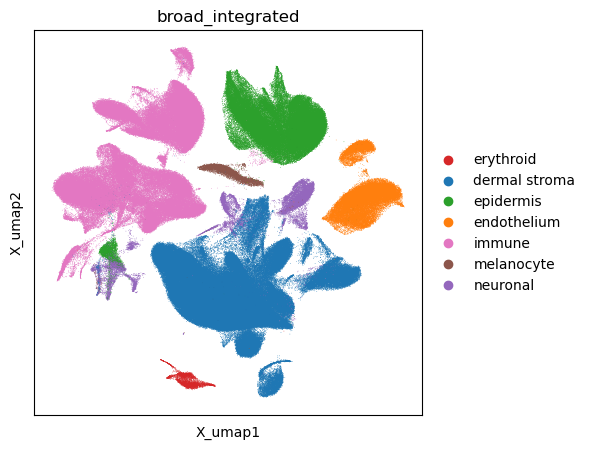

In [93]:
sk.set_figsize((5, 5))
sc.pl.embedding(pooled_ad, basis='X_umap', color=['broad_integrated'], s=1,
                      palette={'erythroid': 'tab:red',
                                'dermal stroma': 'tab:blue', 
                                'epidermis': 'tab:green',
                                'endothelium': 'tab:orange',
                                'immune': 'tab:pink' ,
                                'melanocyte': 'tab:brown' ,
                                'neuronal': 'tab:purple'},)
               #save = 'integrated_umap_broad1.pdf')

In [94]:
print(pooled_ad.obs['broad_integrated'].cat.categories)

Index(['erythroid', 'dermal stroma', 'epidermis', 'endothelium', 'immune',
       'melanocyte', 'neuronal'],
      dtype='object')


In [95]:
# now set colour values:
pooled_ad.uns['broad_integrated_colors'] = ['tab:red',
                                         'tab:blue', 
                                         'tab:green',
                                         'tab:orange',
                                         'tab:pink' ,
                                         'tab:brown',
                                         'tab:purple']

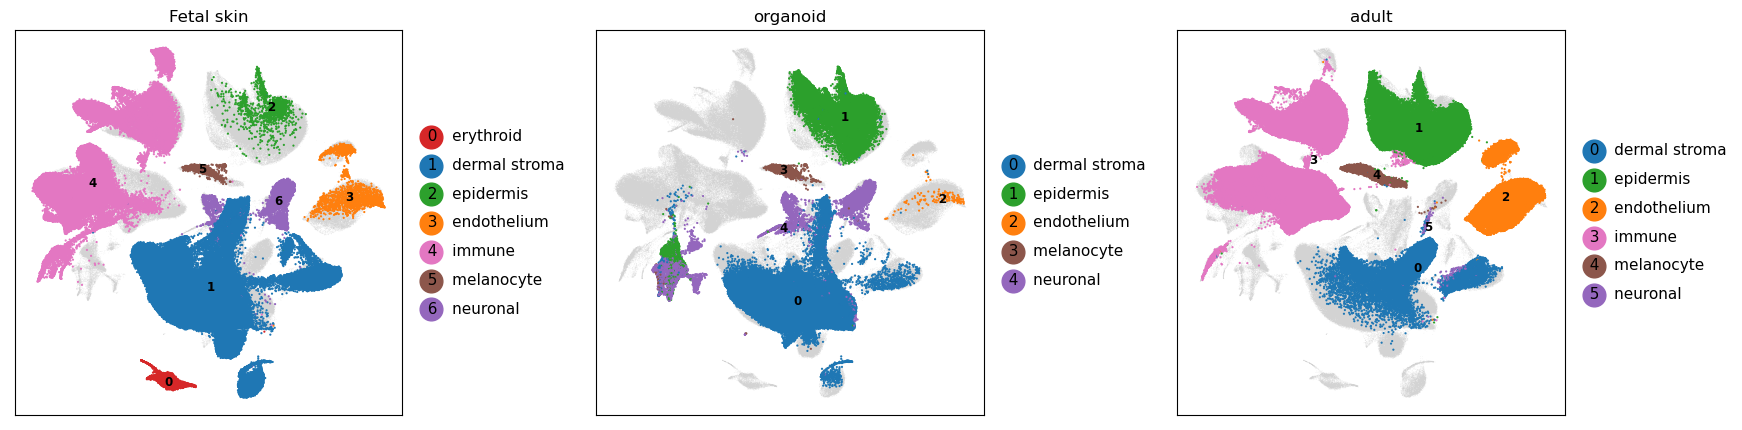

In [96]:
sk.set_figsize((20, 5))
fig, axs = plt.subplots(nrows=1, ncols=3, gridspec_kw={"wspace": 0.5})

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[0])
sk.plot_embedding(pooled_ad_fs,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",           
    title="Fetal skin",
    ax=axs[0],
    show=False)

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[1])
sk.plot_embedding(pooled_ad_or,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    title="organoid",
    ax=axs[1],
    show=False)

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[2])
sk.plot_embedding(pooled_ad_at,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    title="adult",
    ax=axs[2],
    show=False)

axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[2].set_xlabel("")
axs[2].set_ylabel("")
#fig.savefig("/home/jovyan/projects/skin/fetal_skin/figures/other plots/Fig1_split_umaps2.pdf", bbox_inches="tight")
gc.collect();

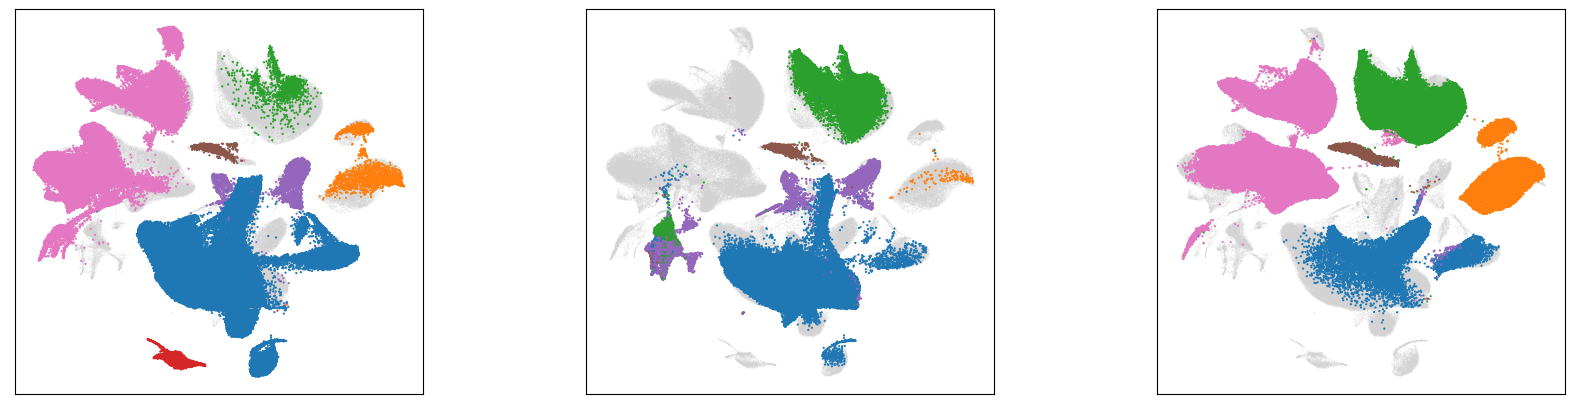

In [97]:
sk.set_figsize((20, 5))
fig, axs = plt.subplots(nrows=1, ncols=3, gridspec_kw={"wspace": 0.4})

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[0])
sk.plot_embedding(pooled_ad_fs,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    annot=False,            
    title="Fetal skin",
    ax=axs[0],
    show=False)

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[1])
sk.plot_embedding(pooled_ad_or,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    annot=False,
    title="organoid",
    ax=axs[1],
    show=False)

sc.pl.embedding(pooled_ad, basis="umap", size=0.7, alpha=0.5, show=False, ax=axs[2])
sk.plot_embedding(pooled_ad_at,
    basis="umap",
    groupby="broad_integrated",
    size=10,
    legend_fontsize=10,
    #legend_loc="right",
    annot=False,
    title="adult",
    ax=axs[2],
    show=False)

axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[2].set_xlabel("")
axs[2].set_ylabel("")
#fig.savefig("/home/jovyan/projects/skin/fetal_skin/figures/other plots/Fig1_split_umaps2_noannot3_26062023.pdf", bbox_inches="tight")
gc.collect();

# Fetal vs adult vs skin organoid: Distance calculation

In [6]:
pooled_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/pooled_fetal_organoid_adult.processed.h5ad'
pooled_ad0 = sc.read(pooled_path)

In [7]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'annot', 'independent_annotation_refined_20220202', 'day', 'sample_

In [10]:
pooled_ad0.obsm['X_pca_project']

array([[16.79672344,  7.69896235,  0.74638107, ...,  1.16263719,  2.87401458,  3.0007605 ],
       [21.49300754, 17.29920297, -3.73816564, ..., -0.68993247, -0.1882623 , -2.24756087],
       [18.28446135, 10.82307616,  0.05133113, ...,  1.05286661,  2.42141511,  2.6161379 ],
       ...,
       [13.19031059,  3.45924548, -5.63700383, ...,  0.11559961, -0.16682576, -1.74217419],
       [14.51853205,  4.71544251, -5.59856386, ...,  0.7473179 ,  0.84863831, -1.25455024],
       [11.30360132,  1.95595675, -5.10440056, ...,  0.6690941 , -1.28370374, -0.35061935]])

In [11]:
pooled_ad0.obsp['neighbors_project_connectivities']

<506107x506107 sparse matrix of type '<class 'numpy.float32'>'
	with 11564466 stored elements in Compressed Sparse Row format>

In [8]:
pb_annot_pca = sk.pseudo_bulk(pooled_ad0, groupby="annot", use_rep="X_pca_project", FUN=np.median).T

In [9]:
pb_annot_pca

pca_project1  pca_project2  pca_project3  \
adult_DC                          13.886434      7.556249     -3.261260   
adult_Fibroblast                  17.317607     -6.278398      1.161614   
adult_ILC                         11.905485      6.497681     -5.069853   
adult_Keratinocyte                11.751297     -1.136976     -2.503007   
adult_Lymphatic endothelium       17.273733     -2.852778      9.699170   
adult_Macrophage                  16.114019      8.757612     -1.476601   
adult_Mast cell                   13.466662      2.719056     -4.805234   
adult_Melanocyte                  15.065735     -4.227886     -9.441007   
adult_Monocyte                    15.127033     10.703071     -2.185618   
adult_Mural cell                  16.090280     -6.792359      2.655448   
adult_Plasma cell                 10.377655      2.610531     -3.870766   
adult_Schwann cell                16.671470     -6.500277      0.222869   
adult_T cell                      11.437036      3.995057     -4.971307   
adult_Vascular endothelium        19.678667     -2.113674     17.663383   
fetal_Adipocyte                   15.825793     -5.970950      1.012731   
fetal_B cell                      11.353915      3.990216     -3.896650   
fetal_DC                          15.384112      9.522161     -3.506146   
fetal_Erythroid                   11.102024      0.210335     -2.575391   
fetal_Fibroblast                  16.492730     -6.573412      0.571901   
fetal_Haem progenitor             13.189791      3.478171     -4.184333   
fetal_ILC                         11.853496      7.132792     -4.840174   
fetal_Keratinocyte                13.025025     -1.534655     -3.455007   
fetal_Lymphatic endothelium       17.825843     -2.558848     11.552864   
fetal_Macrophage                  17.685992      9.420274     -1.068379   
fetal_Mast cell                   13.992446      3.108634     -5.045363   
fetal_Megakaryocyte               16.289396      4.701283     -2.237614   
fetal_Melanocyte                  16.510240     -4.904591    -11.555473   
fetal_Monocyte                    17.157641     13.378841     -2.410204   
fetal_Mural cell                  16.910023     -7.112242      3.104043   
fetal_Neuronal cell               14.346155     -4.703341     -6.588352   
fetal_Neutrophil                  11.983744      7.784487     -3.111596   
fetal_Schwann cell                17.841512     -9.046663     -5.379542   
fetal_Skeletal muscle             13.735102     -3.588515     -0.805572   
fetal_T cell                      11.756515      4.651437     -4.925078   
fetal_Vascular endothelium        20.553090     -1.978070     20.088877   
organoid_Adipocyte                16.686036     -5.758230      1.352926   
organoid_Fibroblast               14.694871     -5.329553      0.334915   
organoid_Keratinocyte             12.311702     -0.699240     -2.913180   
organoid_Melanocyte               15.934357     -4.442130    -10.789844   
organoid_Mural cell               15.664141     -5.893982      2.342924   
organoid_Neuronal cell            13.663923      3.460176     -5.321272   
organoid_Schwann cell             16.960737     -7.792797     -4.931147   
organoid_Skeletal muscle          12.554923     -1.080297     -2.121031   
organoid_Vascular endothelium     21.045479     -2.077594     20.276521   

                               pca_project4  pca_project5  pca_project6  \
adult_DC                           0.746877     -1.412675      1.678644   
adult_Fibroblast                   9.094196      1.010300      0.951450   
adult_ILC                         -3.941593      9.471567     -3.333407   
adult_Keratinocyte                -4.522794      0.470394     12.239385   
adult_Lymphatic endothelium       -5.534894     -0.421206     -1.062056   
adult_Macrophage                   4.147018     -4.560939      0.586990   
adult_Mast cell                   -3.856395      2.551853      1.286509   
adult_Melanocyte                 -10.371566    -18.2851

In [12]:
annot_dist_df = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_pca.values, pb_annot_pca.values),
    index=pb_annot_pca.index,
    columns=pb_annot_pca.index,
)

In [13]:
annot_dist_df.iloc[0:5, 0:5]

adult_DC  adult_Fibroblast  adult_ILC  \
adult_DC                      0.000000         22.743514  19.770160   
adult_Fibroblast             22.743514          0.000000  24.312267   
adult_ILC                    19.770160         24.312267   0.000000   
adult_Keratinocyte           20.546140         22.101174  22.047895   
adult_Lymphatic endothelium  23.559779         22.064964  25.128487   

                             adult_Keratinocyte  adult_Lymphatic endothelium  
adult_DC                              20.546140                    23.559779  
adult_Fibroblast                      22.101174                    22.064964  
adult_ILC                             22.047895                    25.128487  
adult_Keratinocyte                     0.000000                    22.852923  
adult_Lymphatic endothelium           22.852923                     0.000000

In [14]:
ct_shared_by_all = (
    annot_dist_df.index.to_series()
    .str.partition("_", expand=True)[2]
    .value_counts()
    .where(lambda x: x == 3)
    .dropna()
    .index
)

In [15]:
annot_dist_df_shared = annot_dist_df.loc[
    annot_dist_df.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
    annot_dist_df.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
]

In [16]:
annot_scaled_dist_df_shared = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df_shared)),
    index=annot_dist_df_shared.index,
    columns=annot_dist_df_shared.index,
)

In [17]:
annot_scaled_dist_df_shared.columns

Index(['adult_Fibroblast', 'adult_Keratinocyte', 'adult_Melanocyte',
       'adult_Mural cell', 'adult_Schwann cell', 'adult_Vascular endothelium',
       'fetal_Fibroblast', 'fetal_Keratinocyte', 'fetal_Melanocyte',
       'fetal_Mural cell', 'fetal_Schwann cell', 'fetal_Vascular endothelium',
       'organoid_Fibroblast', 'organoid_Keratinocyte', 'organoid_Melanocyte',
       'organoid_Mural cell', 'organoid_Schwann cell',
       'organoid_Vascular endothelium'],
      dtype='object')

In [18]:
fig1d_ct_order = [
    "adult_Keratinocyte",
    "fetal_Keratinocyte",
    "organoid_Keratinocyte",
    "adult_Melanocyte",
    "fetal_Melanocyte",
    "organoid_Melanocyte",
    "adult_Fibroblast",
    "fetal_Fibroblast",
    "organoid_Fibroblast",
    "adult_Mural cell",
    "fetal_Mural cell",
    "organoid_Mural cell",
    "adult_Schwann cell",
    "fetal_Schwann cell",
    "organoid_Schwann cell",
    "adult_Vascular endothelium",
    "fetal_Vascular endothelium",
    "organoid_Vascular endothelium",
]

fig1d_df = annot_scaled_dist_df_shared[fig1d_ct_order].loc[fig1d_ct_order].T

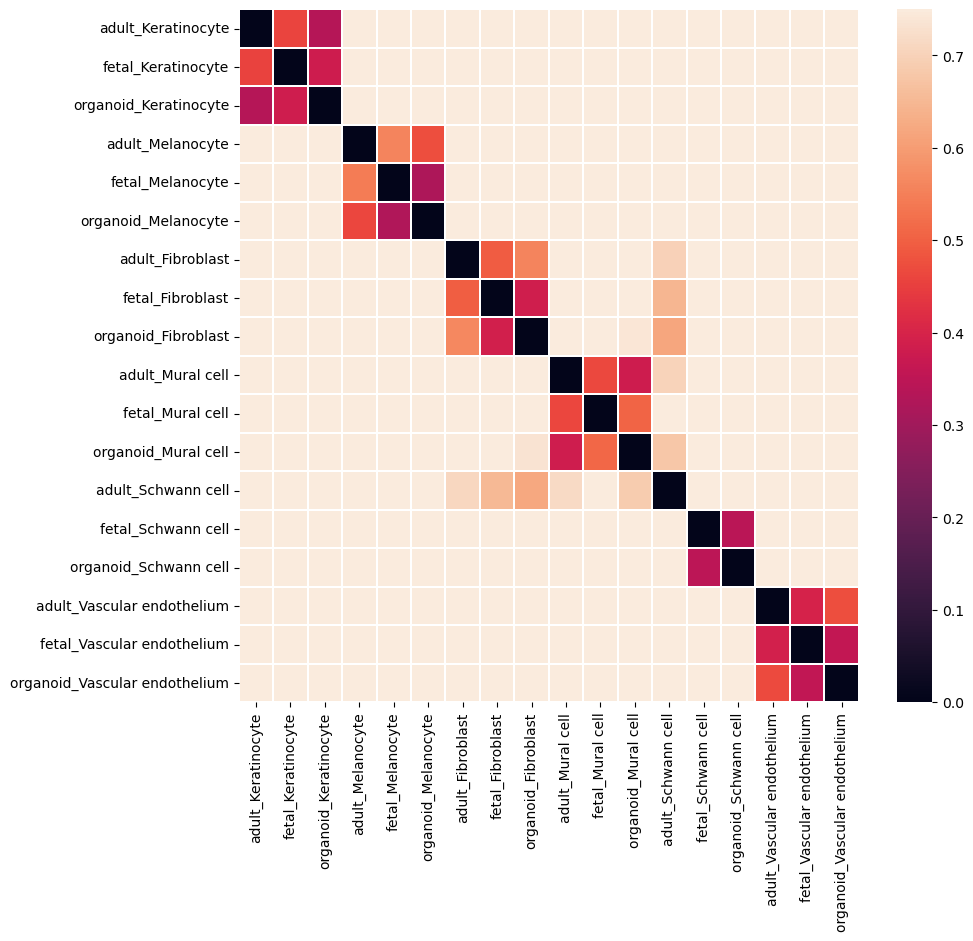

In [19]:
fig1D_g = sk.heatmap(fig1d_df, figsize=(10, 9), vmax=0.75, linewidth=0.01)
fig1D_g.figure.savefig("figures/fig1E.20230624.pdf", bbox_inches="tight")

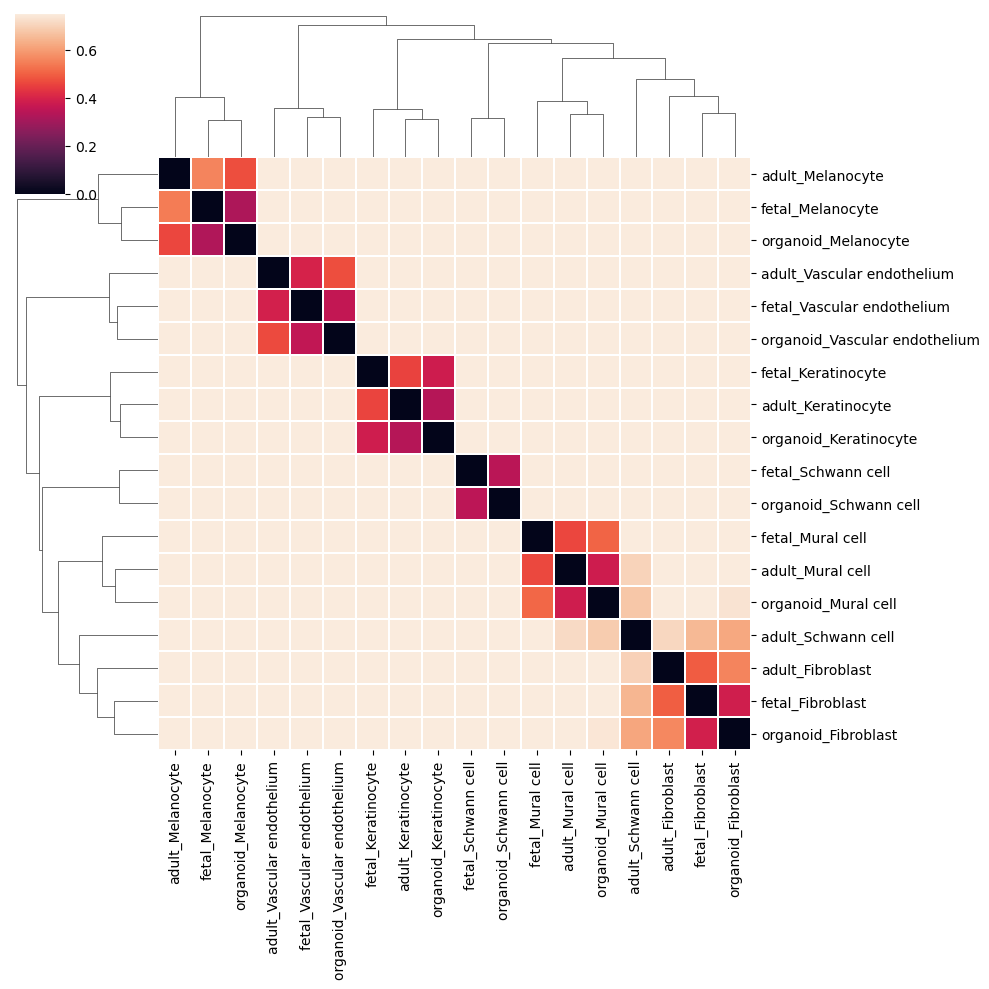

In [20]:
fig1D_g = sn.clustermap(annot_scaled_dist_df_shared.T, figsize=(10, 10), vmax=0.75, linewidth=0.01)
#fig1D_g.savefig("figures/fig1D_p1a.pdf")

In [17]:
#annot_scaled_dist_df_shared = annot_scaled_dist_df_shared.loc[
#    ~annot_scaled_dist_df_shared.index.str.startswith("fetal_"),
#    annot_scaled_dist_df_shared.index.str.startswith("fetal_"),
#]

In [21]:
annot_scaled_dist_df = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df)),
    index=annot_dist_df.index,
    columns=annot_dist_df.index,
)

In [22]:
figS1h_ct_order = [
    "adult_Keratinocyte",
    "fetal_Keratinocyte",
    "organoid_Keratinocyte",
    "adult_Melanocyte",
    "fetal_Melanocyte",
    "organoid_Melanocyte",
    #"fetal_Dermal papillia",
    #"organoid_Dermal papillia",
    "fetal_Adipocyte",
    "organoid_Adipocyte",
    "adult_Fibroblast",
    "fetal_Fibroblast",
    #"fetal_Myofibroblast",
    "organoid_Fibroblast",
    "adult_Schwann cell",
    "fetal_Schwann cell",
    "organoid_Schwann cell",
    "fetal_Skeletal muscle",
    "organoid_Skeletal muscle",
    "adult_Mural cell",
    "fetal_Mural cell",
    "organoid_Mural cell",
    "adult_Vascular endothelium",
    "fetal_Vascular endothelium",
    "organoid_Vascular endothelium",
    "adult_Lymphatic endothelium",
    "fetal_Lymphatic endothelium",
    "fetal_Neuronal cell",
    "organoid_Neuronal cell",
    "fetal_Haem progenitor",
    #"adult_Langerhans cell",
    #"fetal_Langerhans cell",
    "adult_DC",
    "fetal_DC",
    "adult_Monocyte",
    "fetal_Monocyte",
    "adult_Macrophage",
    "fetal_Macrophage",
    "adult_Mast cell",
    "fetal_Mast cell",
    "fetal_Neutrophil",
    "adult_ILC",
    "fetal_ILC",
    "adult_T cell",
    "fetal_T cell",
    #"fetal_pDC",
    "fetal_B cell",
    "adult_Plasma cell",
    "fetal_Erythroid",
    "fetal_Megakaryocyte",
]

figS1h_df = annot_scaled_dist_df[figS1h_ct_order].loc[figS1h_ct_order]

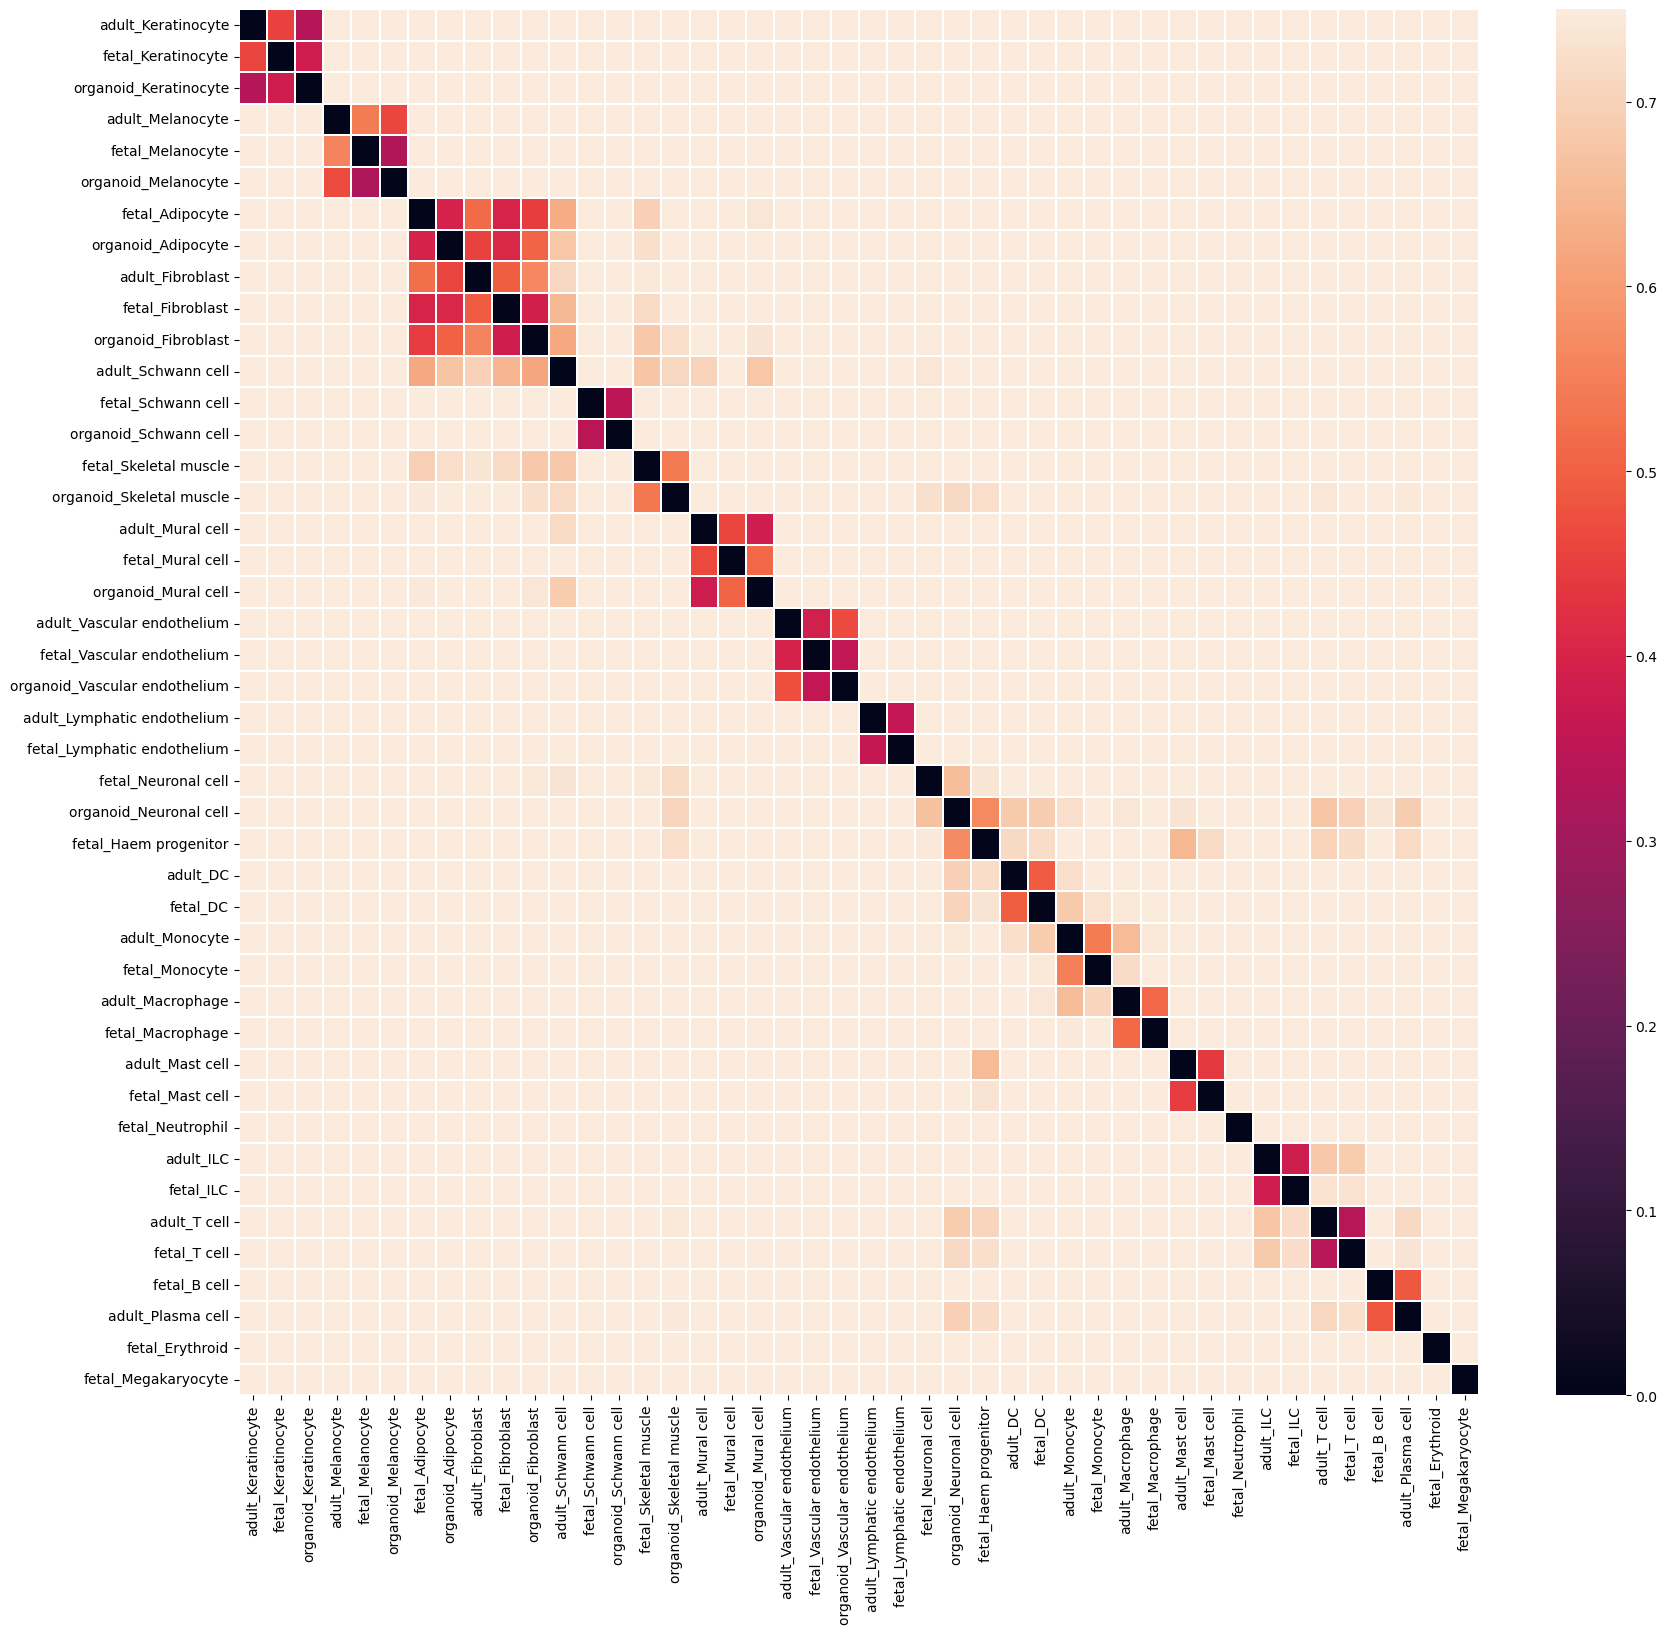

In [23]:
figS1h_g = sk.heatmap(figS1h_df, figsize=(20, 18), vmax=0.75, linewidth=0.01)
#figS1h_g.figure.savefig("figures/figS1h.20220718.pdf", bbox_inches="tight")

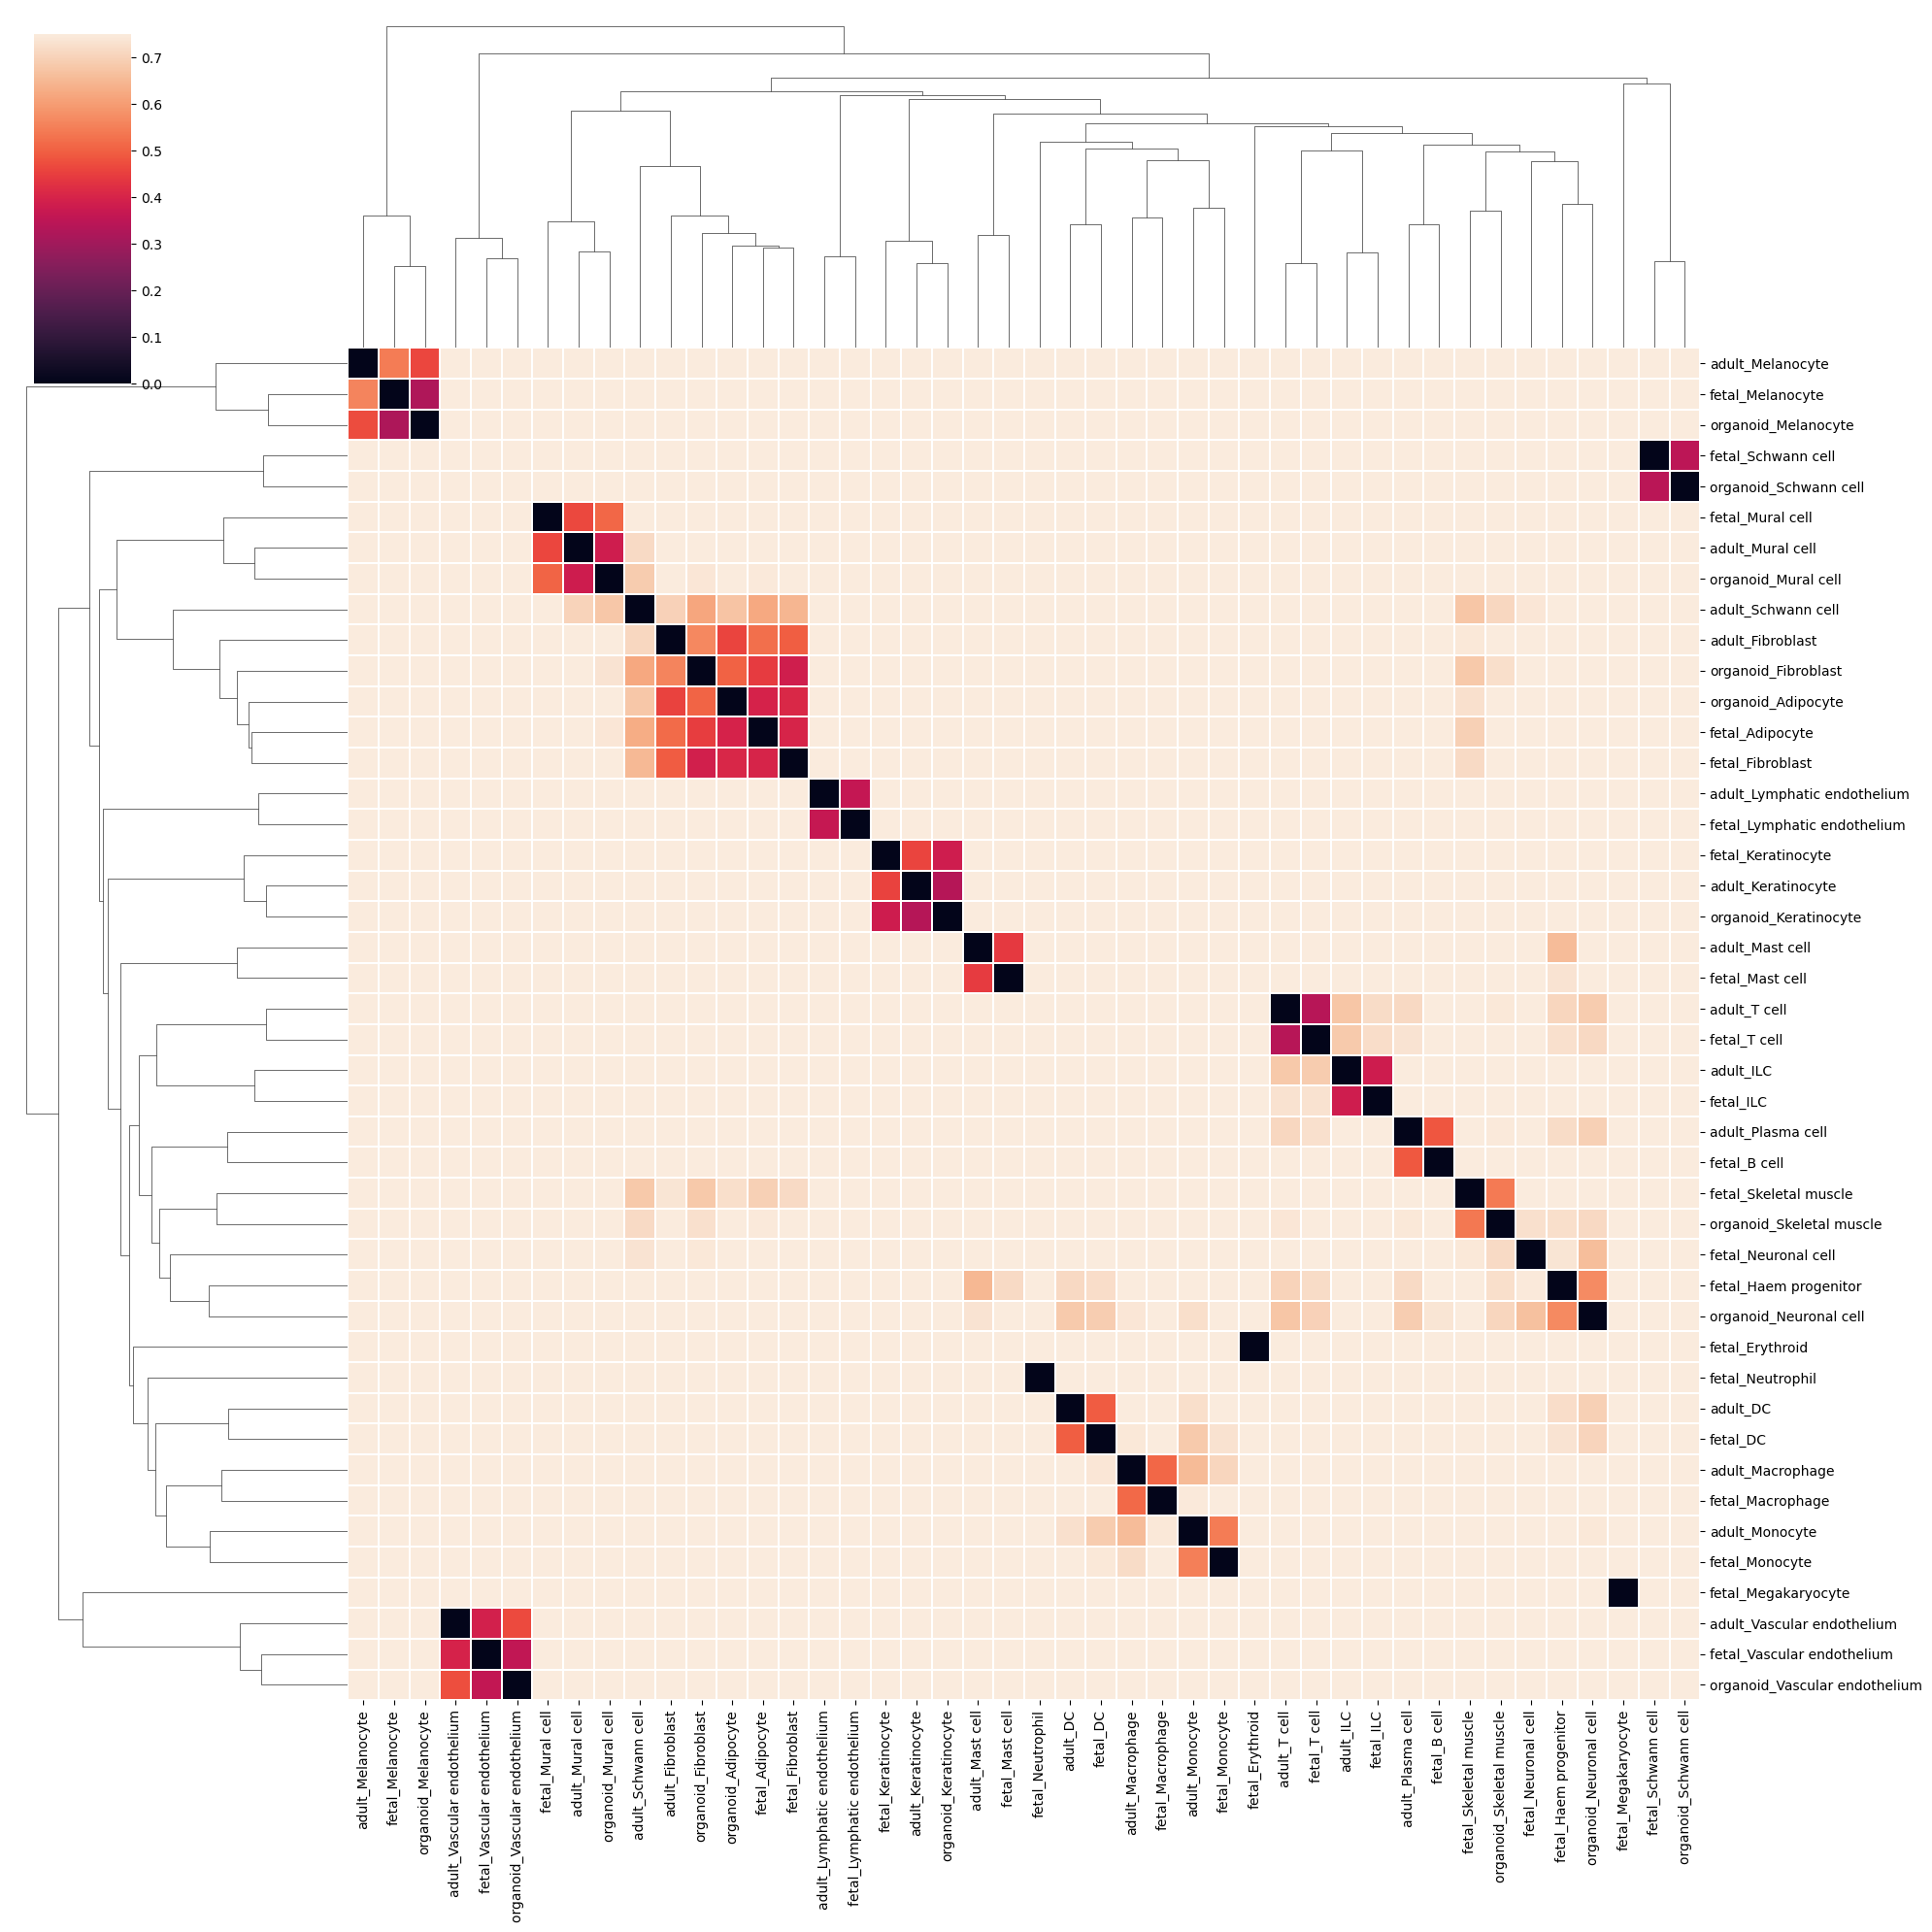

In [24]:
figS1F_g = sn.clustermap(annot_scaled_dist_df, figsize=(20, 20), vmax=0.75, linewidth=0.01)
#figS1F_g.savefig("figures/figS1F_p1.pdf")